In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
import geopandas as gpd

In [2]:
df_before = pd.read_csv("Upwork_Scrapped_Dataset_Before_Preprocessing.csv")

In [ ]:
df_after = pd.read_csv("Upwork_Scrapped_Dataset_After_Preprocessing_Without_Encoding.csv")

In [4]:
df_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3966 non-null   int64  
 1   track_name          3966 non-null   object 
 2   title               3482 non-null   object 
 3   url                 3966 non-null   object 
 4   job_type            3482 non-null   object 
 5   client_location     3478 non-null   object 
 6   description         3482 non-null   object 
 7   min_budget          2853 non-null   object 
 8   max_budget          1505 non-null   object 
 9   fixed_price         2996 non-null   object 
 10  experience_level    3959 non-null   object 
 11  skills              3965 non-null   object 
 12  proposals           3450 non-null   object 
 13  interviewing        3439 non-null   float64
 14  invites_sent        3450 non-null   float64
 15  unanswered_invites  3450 non-null   float64
 16  client

In [5]:
df_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   track_name                       2400 non-null   object 
 1   title                            2400 non-null   object 
 2   url                              2400 non-null   object 
 3   job_type                         2400 non-null   object 
 4   client_location                  2400 non-null   object 
 5   description                      2400 non-null   object 
 6   experience_level                 2400 non-null   object 
 7   skills                           2400 non-null   object 
 8   proposals                        2400 non-null   object 
 9   interviewing                     2400 non-null   float64
 10  invites_sent                     2400 non-null   float64
 11  unanswered_invites               2400 non-null   float64
 12  client_total_spent  

- Job Titles Shared Between Tracks

In [6]:
duplicate_titles_with_tracks = df_before.groupby('title')['track_name'].unique()
# Filter only those appearing in multiple tracks
duplicate_titles_with_tracks = duplicate_titles_with_tracks[duplicate_titles_with_tracks.apply(len) > 1]
# Convert array to readable format
duplicate_titles_with_tracks = duplicate_titles_with_tracks.apply(lambda x: ', '.join(x))
# Display result
test = pd.DataFrame(duplicate_titles_with_tracks)
test['track_name'].value_counts()

track_name
android_developer, javascript_developer                             60
artificial_intelligence, javascript_developer                       30
artificial_intelligence, data_analyst                                8
android_developer, artificial_intelligence                           7
android_developer, artificial_intelligence, javascript_developer     1
data_analyst, javascript_developer                                   1
Name: count, dtype: int64

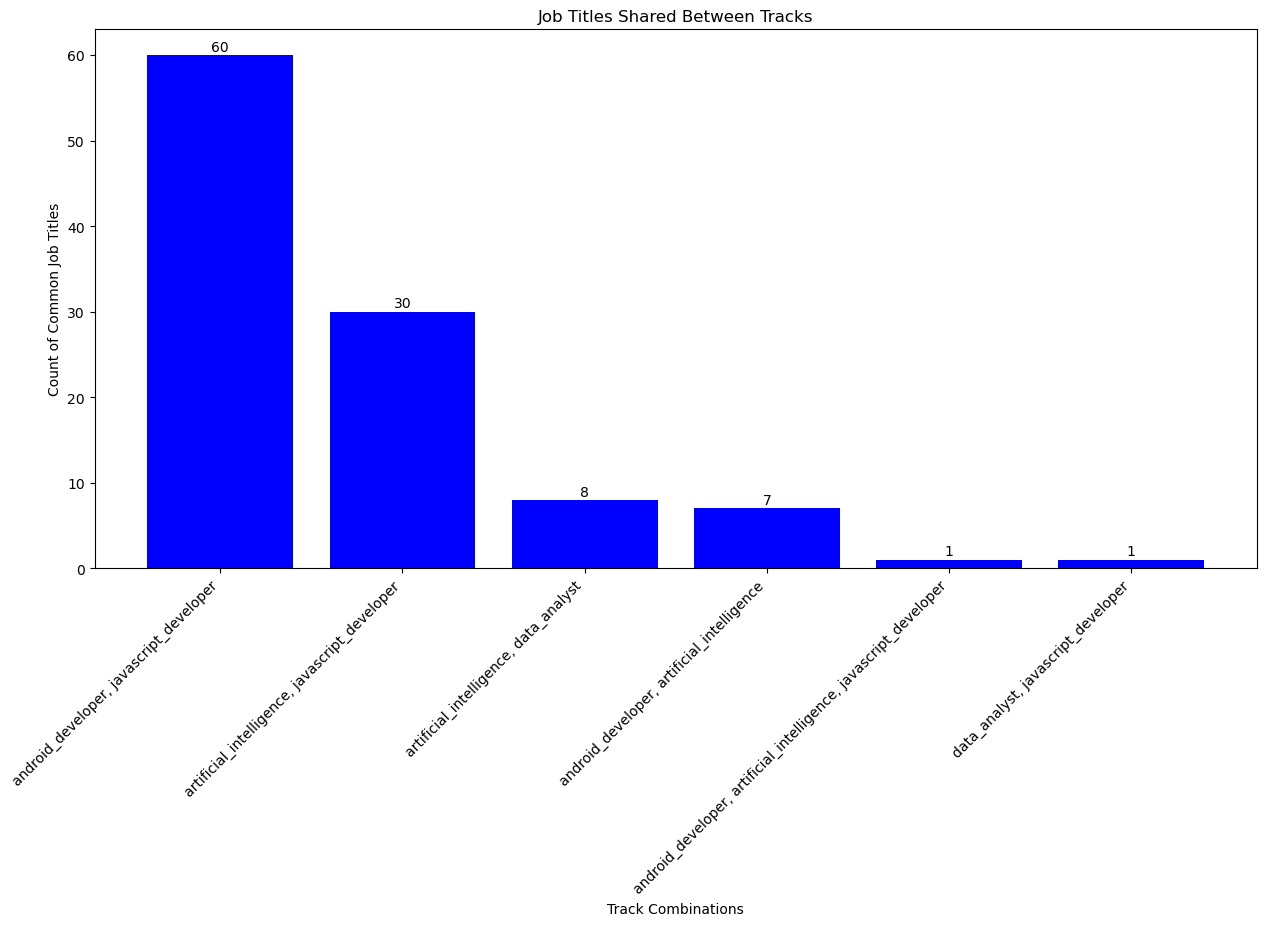

In [7]:
track_counts = test['track_name'].value_counts().sort_values(ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(15, 7))
bars = ax.bar(track_counts.index, track_counts.values, color='blue')

# Set labels and title
ax.set_ylabel("Count of Common Job Titles")
ax.set_xlabel("Track Combinations")
ax.set_title("Job Titles Shared Between Tracks")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(int(bar.get_height())), ha='center', fontsize=10)

plt.show()


- Treemap of Tracks and Skills with Counts

In [15]:
df_before = df_before.dropna(subset=['skills'])
df_before = df_before.dropna(subset=['title'])
df_before['skills1'] = df_before['skills'].apply(ast.literal_eval)
df_before['skills1']

0                          [Flutter, MySQL, Laravel, PHP]
2       [Web Application, C#, JavaScript, PHP, Python,...
3       [Google Play, AI Mobile App Development, Table...
4       [Mobile UI Design, Figma, Responsive Design, W...
7       [Google Play, Tablet, iOS Development, Android...
                              ...                        
3961    [CSS, Database Design, MySQL, Web Development,...
3962    [Web Crawling, Automation, PHP, API, Data Scra...
3963    [Game Development, Web Development, Web Design...
3964    [CSS, Database Design, Web Development, MySQL,...
3965    [softr, CSS, Database Design, Web Development,...
Name: skills1, Length: 3482, dtype: object

In [16]:
# Create a new DataFrame to hold the hierarchical data
hierarchical_data = []

for index, row in df_before.iterrows():
    track = row['track_name']
    skills = row['skills1']
    for skill in skills:
        hierarchical_data.append([track, skill])

# Convert to DataFrame
hierarchical_df = pd.DataFrame(hierarchical_data, columns=['track', 'skill'])
# Add a count column
hierarchical_df['count'] = 1  # Initialize count as 1 for each skill occurrence
# Group by track and skill to get the total count of each skill within each track
hierarchical_df = hierarchical_df.groupby(['track', 'skill'], as_index=False).count()
# Create a new column for displaying the skill and its count together
hierarchical_df['skill_with_count'] = hierarchical_df['skill'] + ' (' + hierarchical_df['count'].astype(str) + ')'

# Add count as text on the rectangles
fig = px.treemap(
    hierarchical_df,
    path=['track', 'skill_with_count'],
    values='count',
    color='track',
    title="Treemap of Tracks and Skills with Counts",
    hover_data={'count': True},  # Show count in hover tooltip
    labels={'count': 'Count'}    # Label for the count in hover
)

# Update layout for better visualization
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25)
)

# Show the figure
fig.show()

- Job Posting Frequency by Track

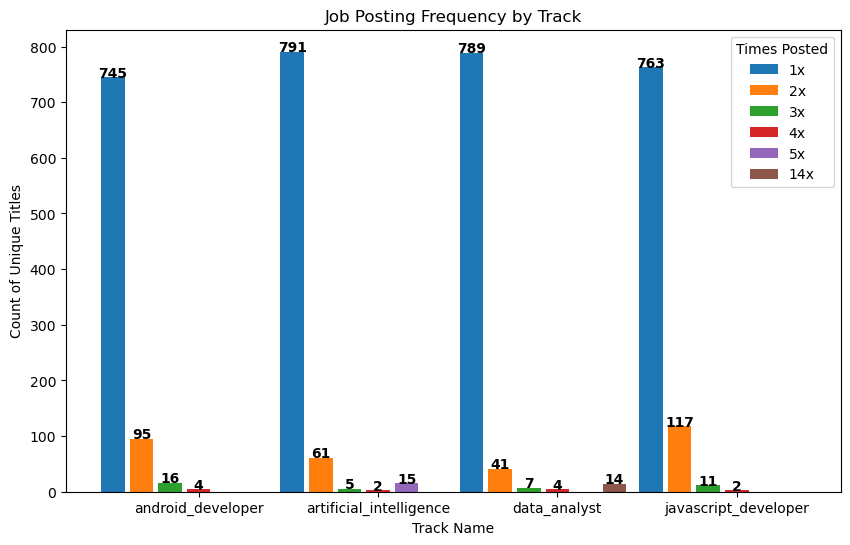

In [18]:
# Count occurrences of each unique title
df_before['count'] = df_before.groupby('title')['title'].transform('count')

# Aggregate by track and job frequency
track_distribution = df_before.groupby(['track_name', 'count']).size().unstack(fill_value=0)

# Define category positions with larger gaps between track names
x_positions = np.linspace(0, len(track_distribution.index) * 2, len(track_distribution.index))

width = 0.35  # Bar width
spacing = 0.075  # Small gap between bars within the same track

fig, ax = plt.subplots(figsize=(10, 6))
bars = []
for i, count in enumerate(track_distribution.columns):
    bars.append(ax.bar(x_positions + (i - len(track_distribution.columns) / 2) * (width + spacing), 
                        track_distribution[count], width, label=f'{count}x'))

ax.set_xticks(x_positions)
ax.set_xticklabels(track_distribution.index)
ax.set_ylabel("Count of Unique Titles")
ax.set_xlabel("Track Name")
ax.set_title("Job Posting Frequency by Track")
ax.legend(title="Times Posted")

# Add value labels
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, str(int(height)), ha='center', fontsize=10, fontweight='bold')

plt.show()


- Filled vs NaN Price per Track

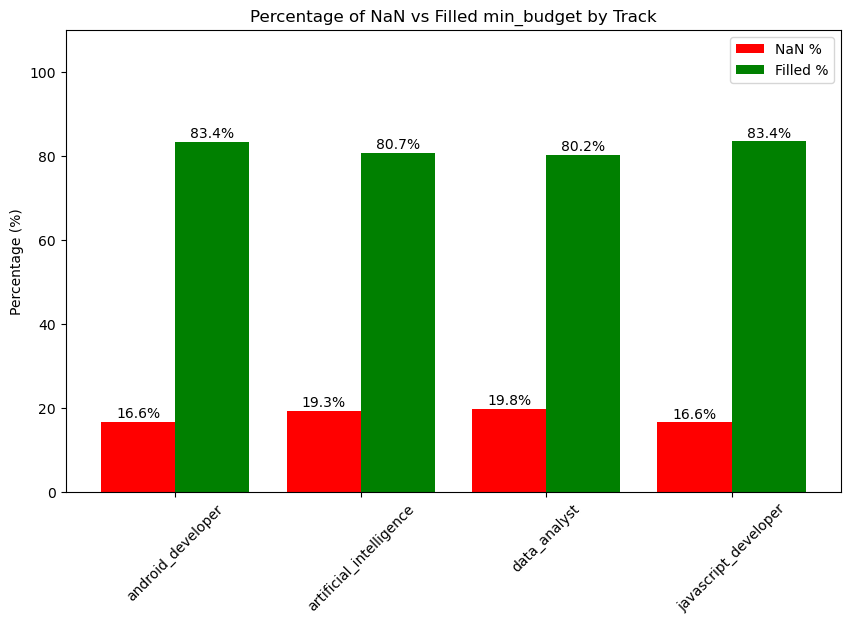

In [20]:
# Compute NaN and Filled percentages per track
track_nan_filled = df_before.groupby('track_name')['min_budget'].apply(lambda x: x.isna().sum()).reset_index(name='NaN')
track_nan_filled['Filled'] = df_before.groupby('track_name')['min_budget'].apply(lambda x: x.notna().sum()).values

# Convert to percentage
track_nan_filled['NaN %'] = (track_nan_filled['NaN'] / (track_nan_filled['NaN'] + track_nan_filled['Filled'])) * 100
track_nan_filled['Filled %'] = (track_nan_filled['Filled'] / (track_nan_filled['NaN'] + track_nan_filled['Filled'])) * 100

# Plot side-by-side bars
x = np.arange(len(track_nan_filled))  # X positions for bars
width = 0.4  # Bar width

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, track_nan_filled['NaN %'], width, color='red', label='NaN %')
bars2 = plt.bar(x + width/2, track_nan_filled['Filled %'], width, color='green', label='Filled %')

# Add text labels above bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.1f}%", ha='center', fontsize=10)

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.1f}%", ha='center', fontsize=10)

# Labels and formatting
plt.ylabel("Percentage (%)")
plt.title("Percentage of NaN vs Filled min_budget by Track")
plt.xticks(x, track_nan_filled['track_name'], rotation=45)
plt.legend()
plt.ylim(0, 110)  # Adjust to ensure text fits

plt.show()


- map for countries by % legend (Mario)

In [29]:
df_after['client_location'].unique()

array(['Australia', 'Switzerland', 'Israel', 'Bangladesh',
       'United Kingdom', 'United States', 'Cyprus', 'Lebanon',
       'Netherlands', 'India', 'Germany', 'Mexico', 'Pakistan', 'Canada',
       'Portugal', 'Spain', 'Belgium', 'Luxembourg', 'Italy', 'ZAF',
       'South Africa', 'Turkmenistan', 'United Arab Emirates', 'Austria',
       'Romania', 'Turkey', 'Malaysia', 'Vietnam', 'Greece', 'LTU',
       'Argentina', 'Brazil', 'Colombia', 'Ukraine', 'Hong Kong',
       'Sweden', 'Kenya', 'Azerbaijan', 'New Zealand', 'Nepal',
       'Slovakia', 'Georgia', 'SAU', 'Singapore', 'Thailand', 'NGA',
       'Nigeria', 'UGA', 'Philippines', 'MAR', 'Ireland', 'Saudi Arabia',
       'Norway', 'Bahrain', 'UKR', 'CHN', 'ESP', 'Peru', 'CYP',
       'Tanzania', 'Uganda', 'Egypt', 'Kuwait', 'Panama', 'KWT',
       'Congo, the Democratic Republic of the', 'NLD', 'France', 'QAT',
       'Denmark', 'LKA', 'Moldova', 'Costa Rica', 'HKG', 'CZE',
       'Mauritania', 'Morocco', 'Finland', 'Bulgaria', 

In [33]:
import pycountry

def get_full_country_name(country):
    try:
        return pycountry.countries.lookup(country).name
    except LookupError:
        return country  # Return as is if not found

df_after['client_location'] = df_after['client_location'].apply(get_full_country_name)


In [34]:
df_after['client_location'].unique()

array(['Australia', 'Switzerland', 'Israel', 'Bangladesh',
       'United Kingdom', 'United States', 'Cyprus', 'Lebanon',
       'Netherlands', 'India', 'Germany', 'Mexico', 'Pakistan', 'Canada',
       'Portugal', 'Spain', 'Belgium', 'Luxembourg', 'Italy',
       'South Africa', 'Turkmenistan', 'United Arab Emirates', 'Austria',
       'Romania', 'Turkey', 'Malaysia', 'Viet Nam', 'Greece', 'Lithuania',
       'Argentina', 'Brazil', 'Colombia', 'Ukraine', 'Hong Kong',
       'Sweden', 'Kenya', 'Azerbaijan', 'New Zealand', 'Nepal',
       'Slovakia', 'Georgia', 'Saudi Arabia', 'Singapore', 'Thailand',
       'Nigeria', 'Uganda', 'Philippines', 'Morocco', 'Ireland', 'Norway',
       'Bahrain', 'China', 'Peru', 'Tanzania, United Republic of',
       'Egypt', 'Kuwait', 'Panama',
       'Congo, The Democratic Republic of the', 'France', 'Qatar',
       'Denmark', 'Sri Lanka', 'Moldova, Republic of', 'Costa Rica',
       'Czechia', 'Mauritania', 'Finland', 'Bulgaria', 'Oman', 'Serbia',
     

In [42]:
data = df_after['client_location'].value_counts()

In [44]:
data.dtype

dtype('int64')

In [45]:
df = pd.DataFrame(list(data.items()), columns=['Country', 'Count'])

In [46]:
df.head()

Country  Count
0   United States   1026
1  United Kingdom    216
2           India    201
3       Australia     99
4          Canada     87

In [47]:
total_entries = 2400
df['Percentage'] = (df['Count'] / total_entries) * 100

In [63]:
df.head()

Country  Count  Percentage
0  United States of America   1026      42.750
1            United Kingdom    216       9.000
2                     India    201       8.375
3                 Australia     99       4.125
4                    Canada     87       3.625

In [55]:
from fuzzywuzzy import process

# Get list of country names from `world`
world_countries = world["ADMIN"].unique()

# Function to find the closest match
def match_country(name):
    match, score = process.extractOne(name, world_countries)
    return match if score > 80 else name  # Adjust threshold if needed

# Apply matching to df["Country"]
df["Country"] = df["Country"].apply(match_country)


c:\Users\Hend-PC\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



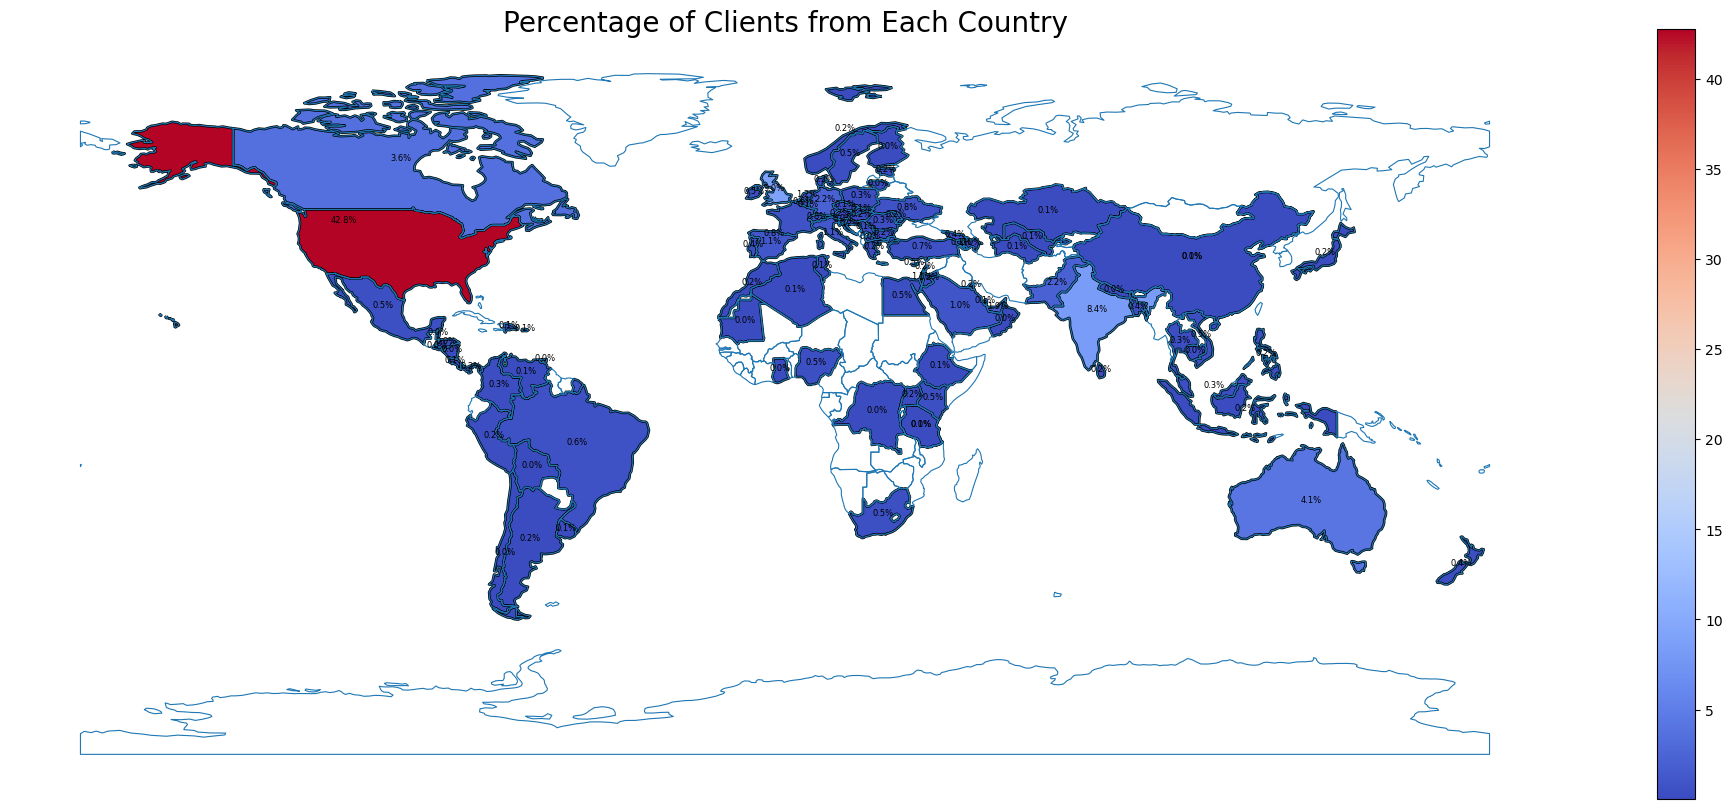

In [69]:

# Load world map dataset
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Merge the computed percentages with world map data
world = world.merge(df[['Country', 'Percentage']], left_on='ADMIN', right_on='Country', how='left')

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

# Plot countries with percentage data
world.boundary.plot(ax=ax, linewidth=0.8)
world.plot(column='Percentage', cmap='coolwarm', linewidth=1.8, edgecolor='black', ax=ax, legend=True)

for idx, row in world.iterrows():
    if not pd.isna(row['Percentage']):  # Ensure only countries with data get labels
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y  # Get country center
        plt.text(x, y, f"{row['Percentage']:.1f}%", fontsize=6, ha='center', color='black')

# Title
plt.title("Percentage of Clients from Each Country", fontsize=20)
plt.axis('off')  # Hide axis

# Show plot
plt.show()


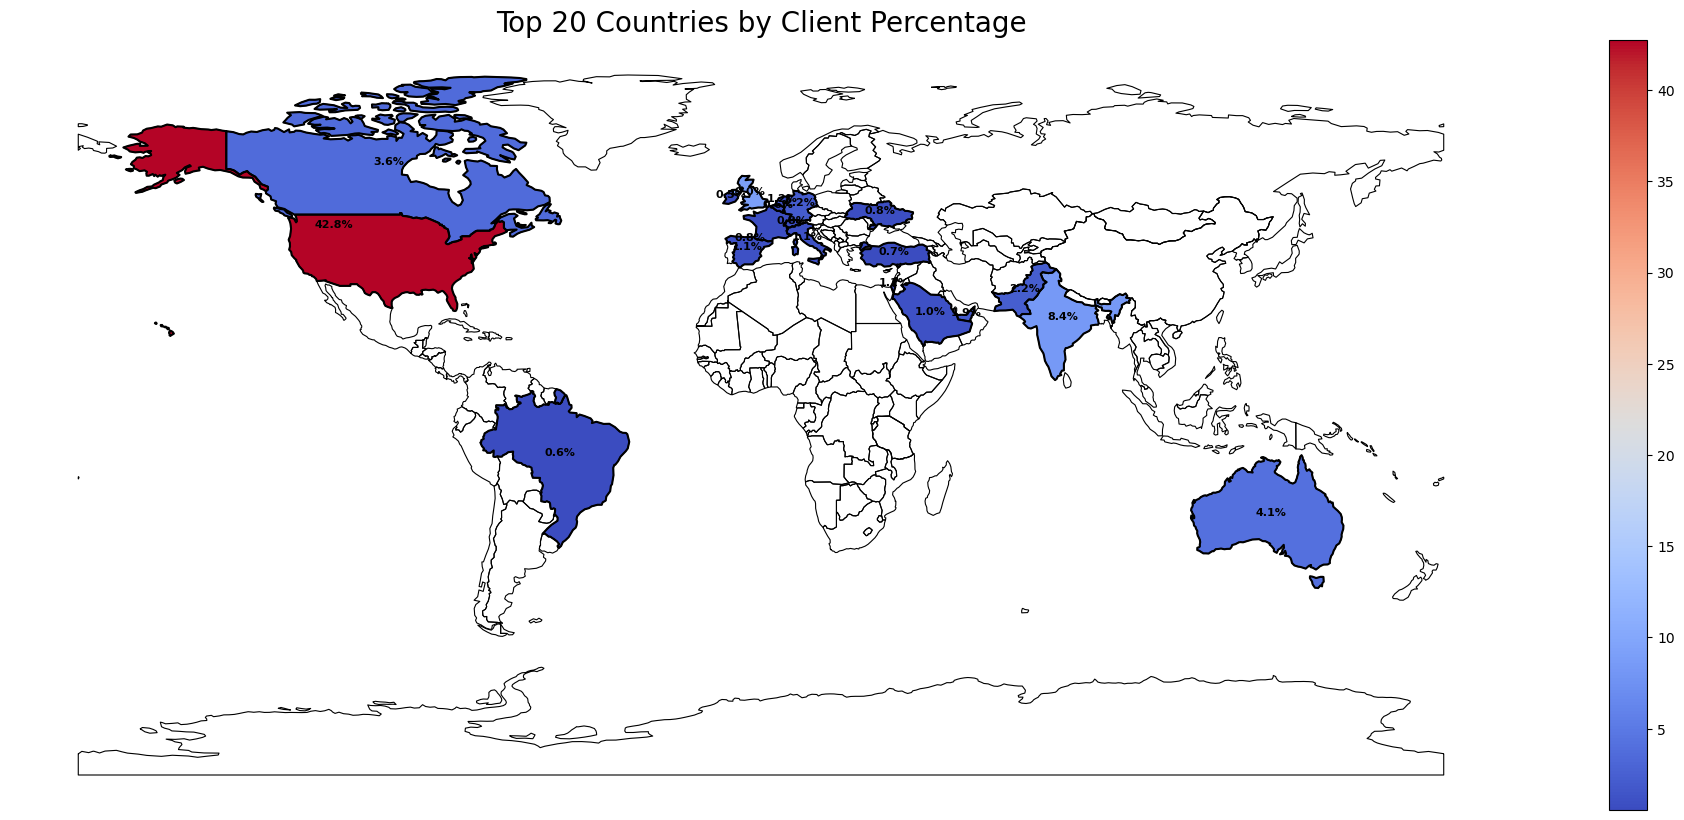

In [ ]:
# Load world map dataset
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Merge the computed percentages with world map data
world = world.merge(df[['Country', 'Percentage']], left_on='ADMIN', right_on='Country', how='left')

# **Filter Top 20 Countries by Percentage**
top_10_countries = world.nlargest(20, 'Percentage')

# Create a new column that keeps values only for the top 20, making others NaN (uncolored)
world['Top20_Percentage'] = world.apply(lambda row: row['Percentage'] if row['Country'] in top_10_countries['Country'].values else None, axis=1)

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

# Plot all country boundaries (keeps them visible but uncolored)
world.boundary.plot(ax=ax, linewidth=0.8, color='black')

# Plot only the **top 20** countries with colors
world.dropna(subset=['Top20_Percentage']).plot(
    column='Top20_Percentage', 
    cmap='coolwarm', 
    linewidth=1.5, 
    edgecolor='black', 
    ax=ax, 
    legend=True
)

# **Add labels only for top 20 countries**
for idx, row in top_10_countries.iterrows():
    if not pd.isna(row['Percentage']):  # Ensure only countries with data get labels
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y  # Get country center
        plt.text(x, y, f"{row['Percentage']:.1f}%", fontsize=8, ha='center', color='black', fontweight='bold')

# Title
plt.title("Top 20 Countries by Client Percentage", fontsize=20)
plt.axis('off')  # Hide axis

# Show plot
plt.show()


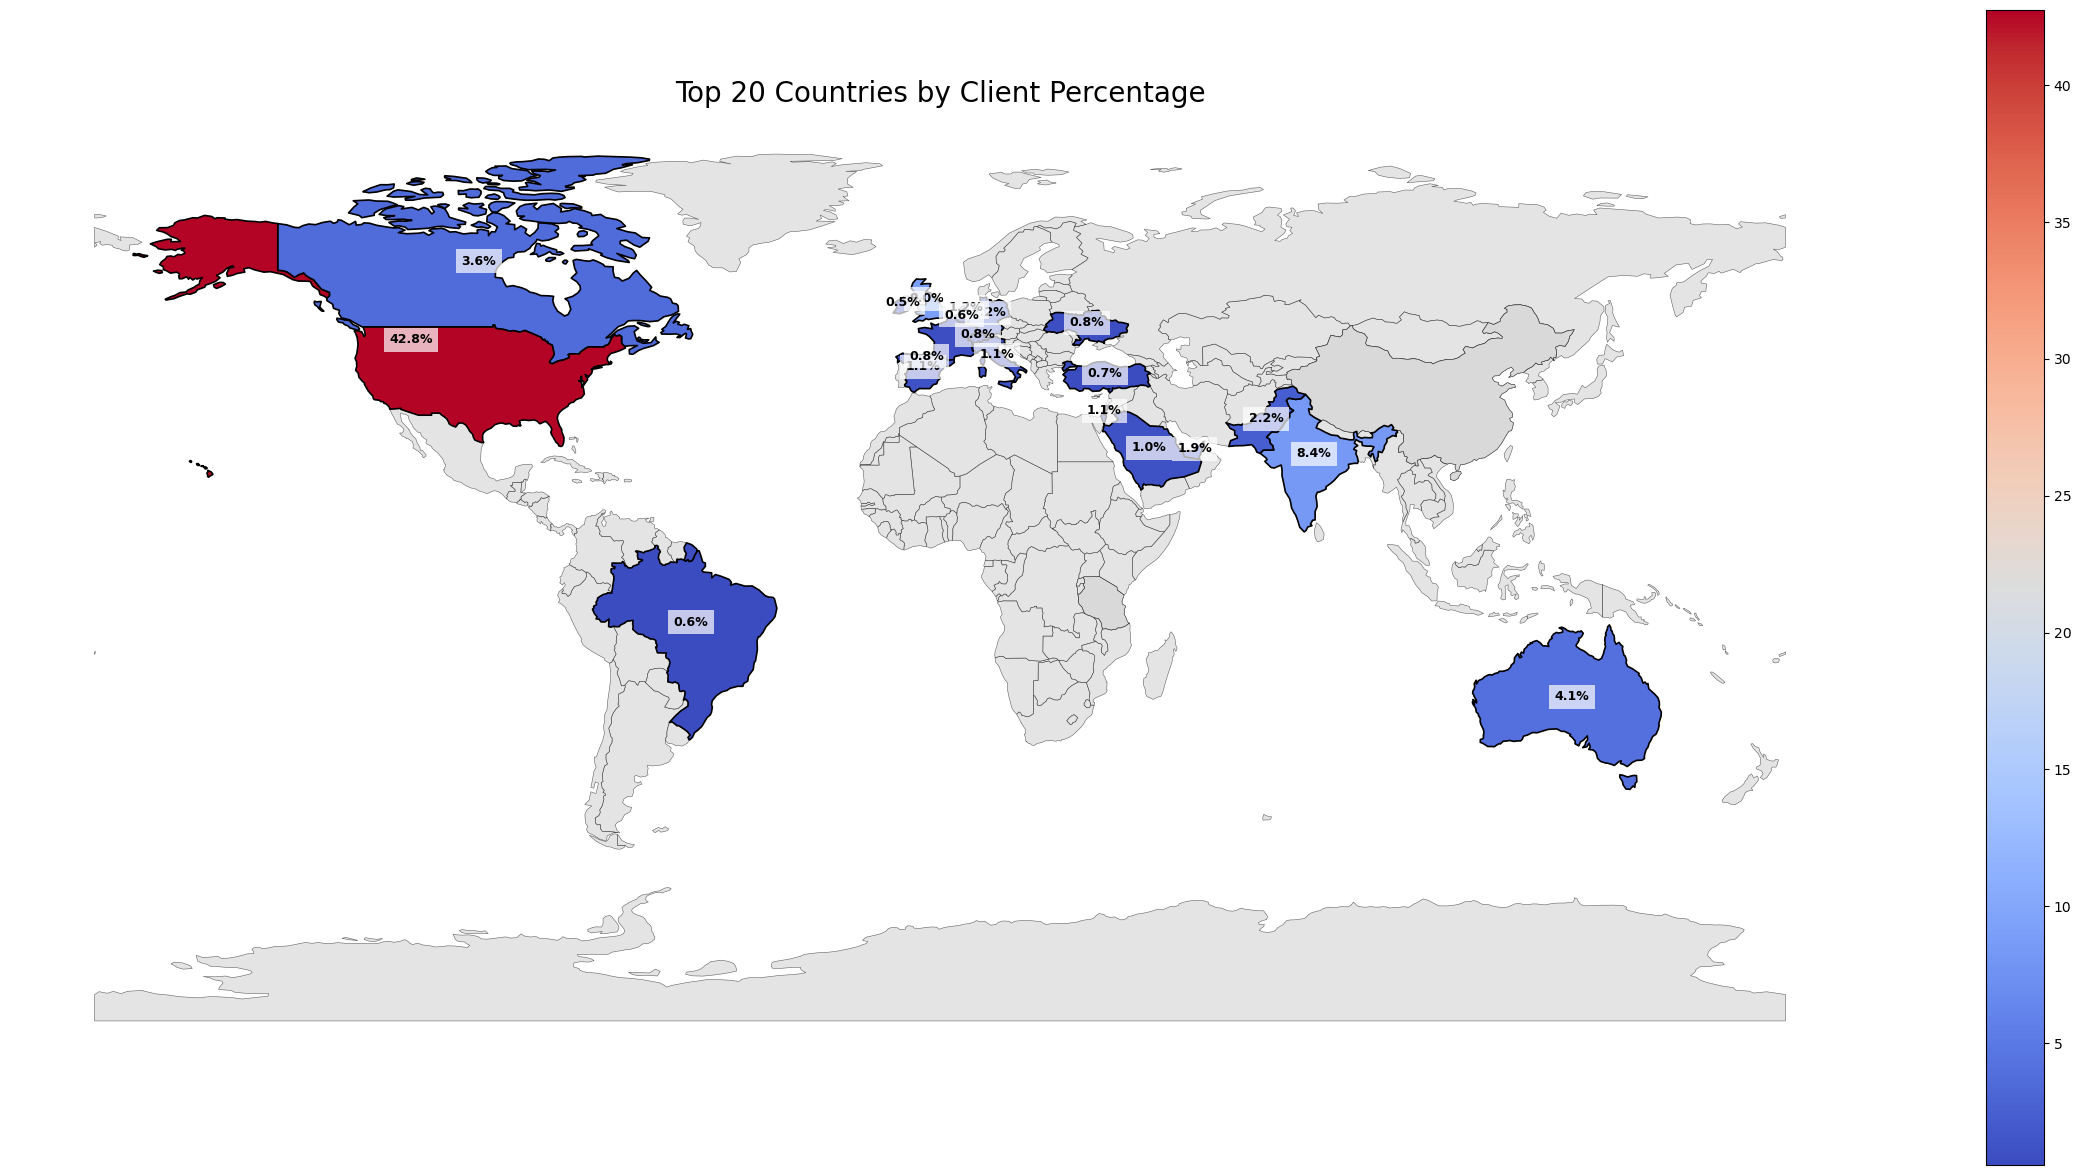

In [ ]:
# Load world map dataset
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Merge the computed percentages with world map data
world = world.merge(df[['Country', 'Percentage']], left_on='ADMIN', right_on='Country', how='left')

# **Filter Top 20 Countries by Percentage**
top_10_countries = world.nlargest(20, 'Percentage')

# Create a new column that keeps values only for the top 20, making others NaN (uncolored)
world['Top20_Percentage'] = world.apply(lambda row: row['Percentage'] if row['Country'] in top_10_countries['Country'].values else None, axis=1)

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(30, 15))

# **Plot all countries with a light gray fill to keep visibility**
world.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.4, alpha=0.6)

# **Highlight only the top 20 countries with color**
world.dropna(subset=['Top20_Percentage']).plot(
    column='Top20_Percentage', 
    cmap='coolwarm', 
    linewidth=1.2, 
    edgecolor='black', 
    ax=ax, 
    legend=True
)

# **Add labels only for top 20 countries**
for idx, row in top_10_countries.iterrows():
    if not pd.isna(row['Percentage']):  # Ensure only countries with data get labels
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y  # Get country center
        plt.text(x, y, f"{row['Percentage']:.1f}%", fontsize=9, ha='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Title
plt.title("Top 20 Countries by Client Percentage", fontsize=20)
plt.axis('off')  # Hide axis

# Show plot
plt.show()


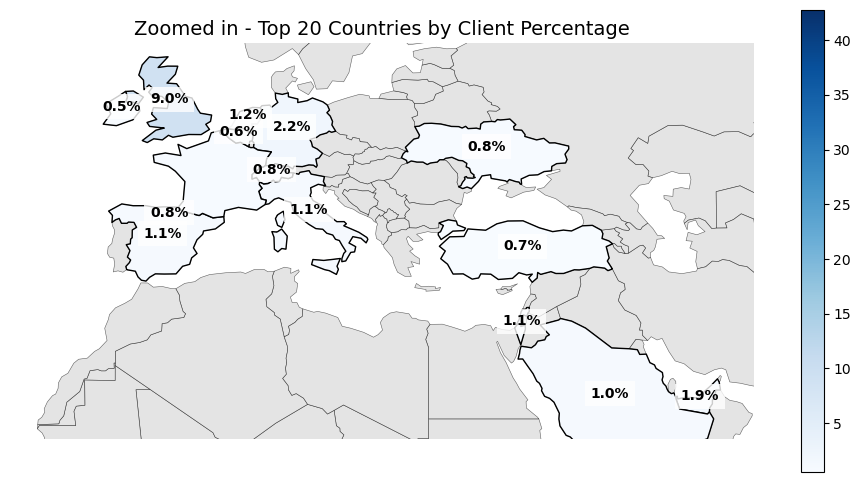

In [ ]:

# Load world map dataset
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Merge world map with client percentage data
world = world.merge(df[['Country', 'Percentage']], left_on='ADMIN', right_on='Country', how='left')

# Ensure numeric values for sorting
world['Percentage'] = pd.to_numeric(world['Percentage'], errors='coerce')

# **Filter Top 20 Countries**
top_10_countries = world.nlargest(20, 'Percentage')

# Set a new column for coloring the top 20 countries only
world['Top20_Percentage'] = world.apply(
    lambda row: row['Percentage'] if row['ADMIN'] in top_10_countries['ADMIN'].values else None, axis=1
)

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# **Plot all countries with a light gray fill**
world.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.4, alpha=0.6)

# **Highlight only the top 20 countries**
top_10_countries.plot(
    column='Percentage', 
    cmap='Blues', 
    linewidth=1, 
    edgecolor='black', 
    ax=ax, 
    legend=True
)

# **Set zoom-in limits**
ax.set_xlim([-20, 60])  # Longitude range
ax.set_ylim([20, 60])   # Latitude range

# **Fix text label placement**
for idx, row in top_10_countries.iterrows():
    if not pd.isna(row['Percentage']) and row.geometry is not None:
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        
        # **Prevent labels from appearing outside map bounds**
        if -20 < x < 60 and 20 < y < 60:
            plt.text(x, y, f"{row['Percentage']:.1f}%", fontsize=10, ha='center', color='black', 
                     fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# **Title and formatting**
plt.title("Zoomed in - Top 20 Countries by Client Percentage", fontsize=14)
plt.axis('off')  # Hide axis

# Show plot
plt.show()


- heatmap for nulls features

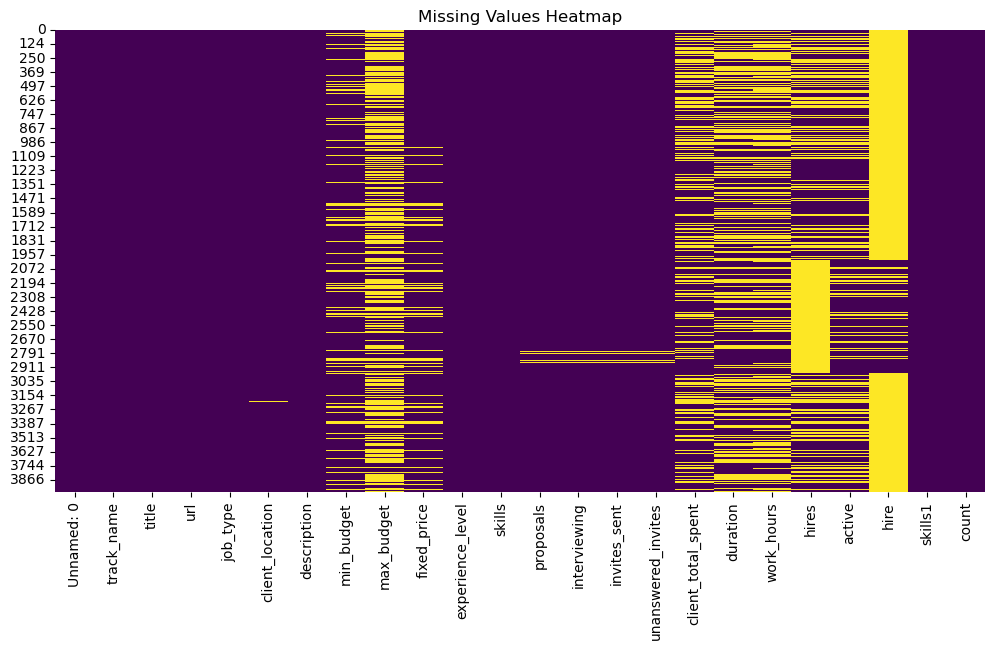

In [83]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_before.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

- budget & loc & experience level relation

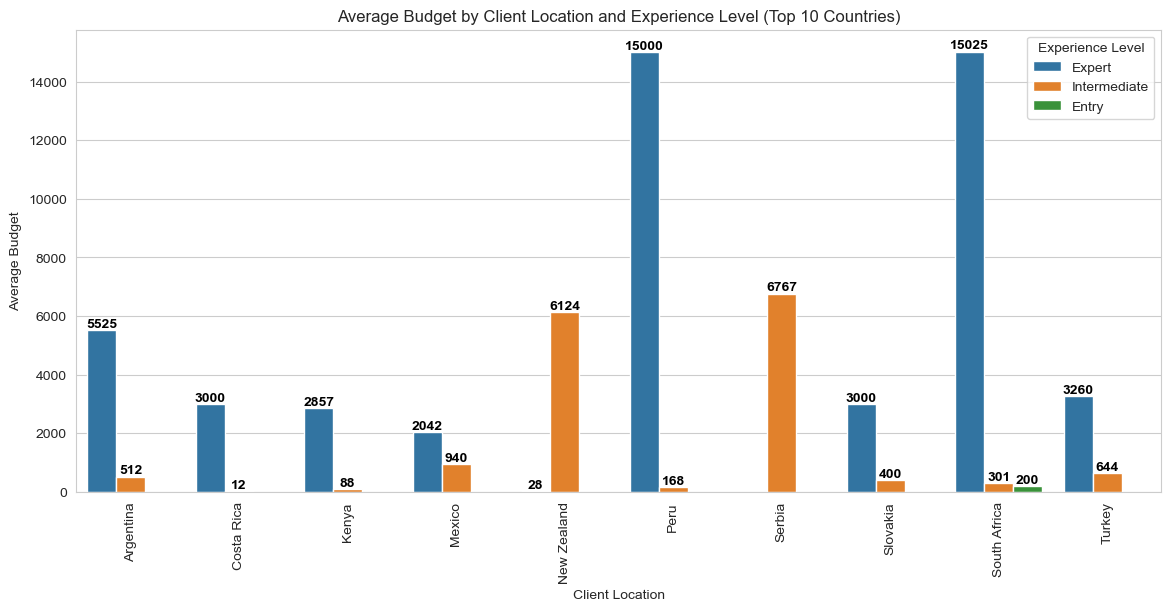

In [95]:
# Step 1: Get the top 10 client locations by average budget
top_10_countries = df_after.groupby("client_location")["average_budget"].mean().nlargest(10).index

# Step 2: Filter the dataframe for only those countries
filtered_df = df_after[df_after["client_location"].isin(top_10_countries)]

# Step 3: Compute the mean budget for each (client_location, experience_level) pair
avg_budget_per_exp = filtered_df.groupby(["client_location", "experience_level"])["average_budget"].mean().reset_index()

# Step 4: Create the bar plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="client_location", y="average_budget", hue="experience_level", data=avg_budget_per_exp)

# Step 5: Add labels above each bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:  # Avoid adding labels to bars with zero height
        ax.annotate(f'{height:.0f}',  
                    (p.get_x() + p.get_width() / 2., height),  
                    ha='center', va='bottom',  
                    fontsize=10, color='black', fontweight='bold')

# Customizations
plt.title("Average Budget by Client Location and Experience Level (Top 10 Countries)")
plt.xlabel("Client Location")
plt.ylabel("Average Budget")
plt.xticks(rotation=90)
plt.legend(title="Experience Level")
plt.show()


- percentage of private job for each track


In [111]:
df = pd.read_csv("Upwork_Scrapped_Dataset_Before_Preprocessing.csv")

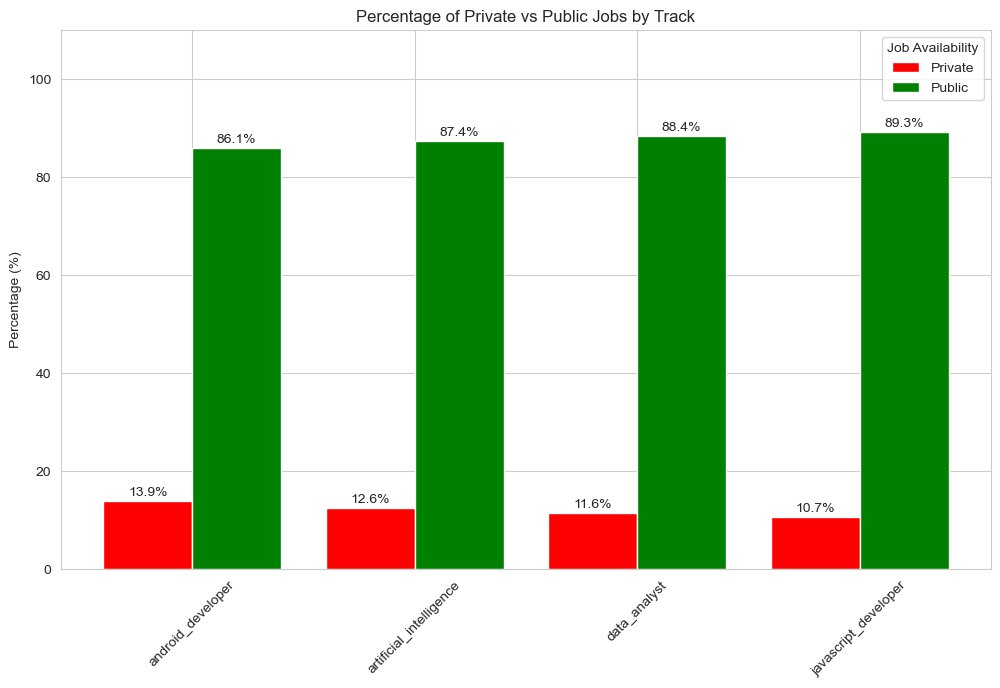

In [102]:
# Replace empty strings with NaN
df['title'] = df['title'].replace('', pd.NA)

# Compute NaN and Filled percentages per track
track_nan_filled = df.groupby('track_name')['title'].apply(lambda x: x.isna().sum()).reset_index(name='NaN')
track_nan_filled['Filled'] = df.groupby('track_name')['title'].apply(lambda x: x.notna().sum()).values

# Convert to percentage
track_nan_filled['NaN %'] = (track_nan_filled['NaN'] / (track_nan_filled['NaN'] + track_nan_filled['Filled'])) * 100
track_nan_filled['Filled %'] = (track_nan_filled['Filled'] / (track_nan_filled['NaN'] + track_nan_filled['Filled'])) * 100

# Plot side-by-side bars
x = np.arange(len(track_nan_filled))  # X positions for bars
width = 0.4  # Bar width

plt.figure(figsize=(12, 7))
bars1 = plt.bar(x - width/2, track_nan_filled['NaN %'], width, color='red', label='Private')
bars2 = plt.bar(x + width/2, track_nan_filled['Filled %'], width, color='green', label='Public')

# Add text labels above bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.1f}%", ha='center', fontsize=10)

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.1f}%", ha='center', fontsize=10)

# Labels and formatting
plt.ylabel("Percentage (%)")
plt.title("Percentage of Private vs Public Jobs by Track")
plt.xticks(x, track_nan_filled['track_name'], rotation=45)
plt.legend(title="Job Availability")  # Legend title
plt.ylim(0, 110)  # Adjust to ensure text fits

plt.show()


- Percentage of Null features

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3966 non-null   int64  
 1   track_name          3966 non-null   object 
 2   title               3482 non-null   object 
 3   url                 3966 non-null   object 
 4   job_type            3482 non-null   object 
 5   client_location     3478 non-null   object 
 6   description         3482 non-null   object 
 7   min_budget          2853 non-null   object 
 8   max_budget          1505 non-null   object 
 9   fixed_price         2996 non-null   object 
 10  experience_level    3959 non-null   object 
 11  skills              3965 non-null   object 
 12  proposals           3450 non-null   object 
 13  interviewing        3439 non-null   float64
 14  invites_sent        3450 non-null   float64
 15  unanswered_invites  3450 non-null   float64
 16  client

In [114]:
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['title'])

C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\787824757.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




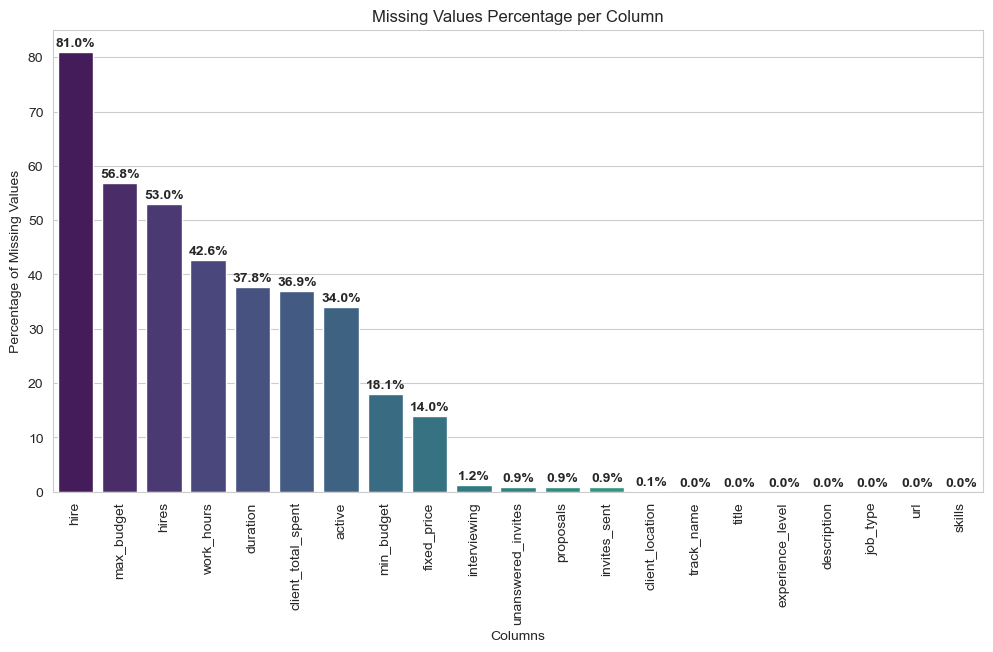

In [116]:
# Calculate missing values and percentage
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_df.index, y=missing_df['Percentage'], palette='viridis')

# Add percentages above bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5,  # Position
            f'{p.get_height():.1f}%',  # Text format
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.ylabel('Percentage of Missing Values')
plt.xlabel('Columns')
plt.title('Missing Values Percentage per Column')

# Show plot
plt.show()


- count work hours by track

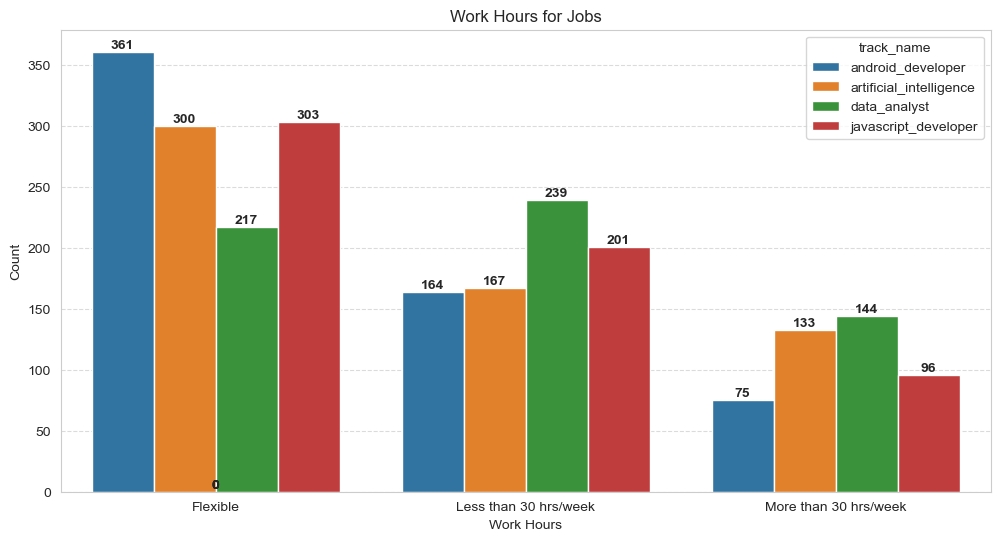

In [118]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_after, x='work_hours', hue='track_name')

# Add count labels above bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,  # X position
            p.get_height() + 0.5,  # Y position (slightly above bar)
            int(p.get_height()),  # Count value
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.title('Work Hours for Jobs')
plt.xlabel('Work Hours')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


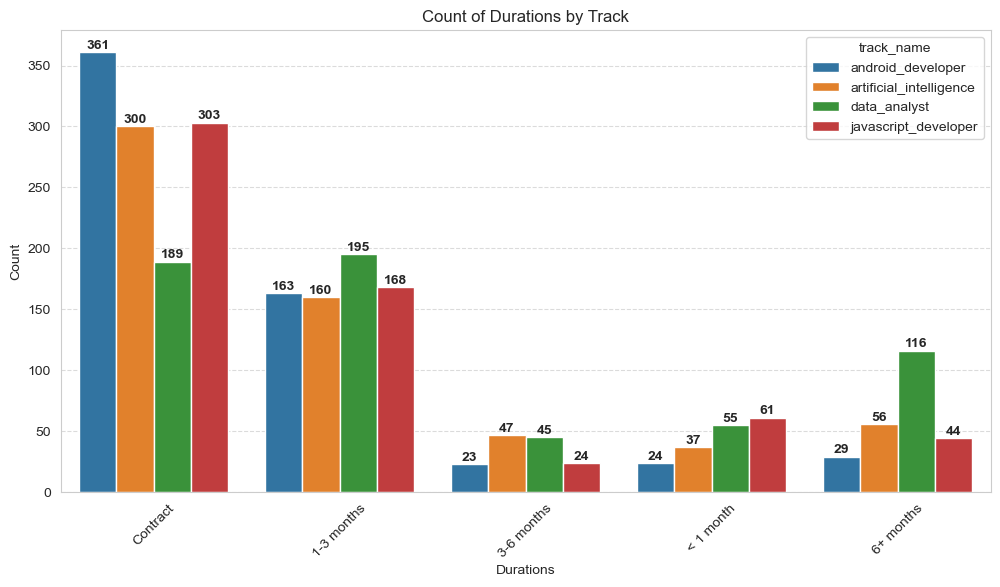

In [122]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_after, x='duration', hue='track_name')

# Add count labels above bars
for p in ax.patches:
    if p.get_height() > 0:  # Skip annotation for zero-height bars
        ax.text(p.get_x() + p.get_width() / 2,  # X position (center of the bar)
                p.get_height() + 0.5,  # Y position (slightly above the bar)
                int(p.get_height()),  # Convert count to integer
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.title('Count of Durations by Track')
plt.xlabel('Durations')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels if needed for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for readability

plt.show()


- count duration and experience level all tracks

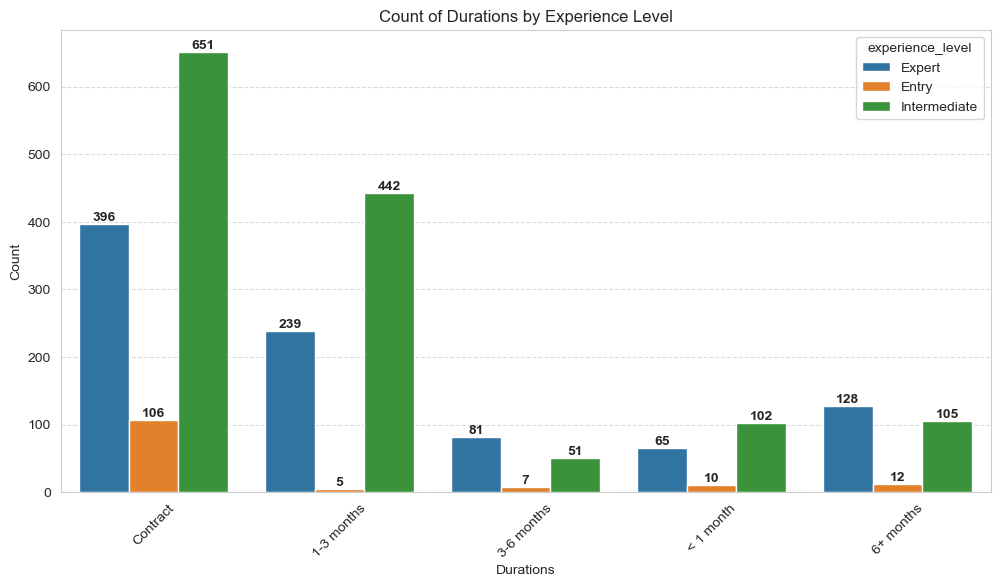

In [121]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_after, x='duration', hue='experience_level')

# Add count labels above bars
for p in ax.patches:
    if p.get_height() > 0:  # Skip annotation for zero-height bars

        ax.text(p.get_x() + p.get_width() / 2,  # Center text above the bar
                p.get_height() + 0.5,  # Position slightly above the bar
                int(p.get_height()),  # Convert count to integer
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.title('Count of Durations by Experience Level')
plt.xlabel('Durations')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels for better visibility if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Light grid for readability

plt.show()


- count duration and experience level by track

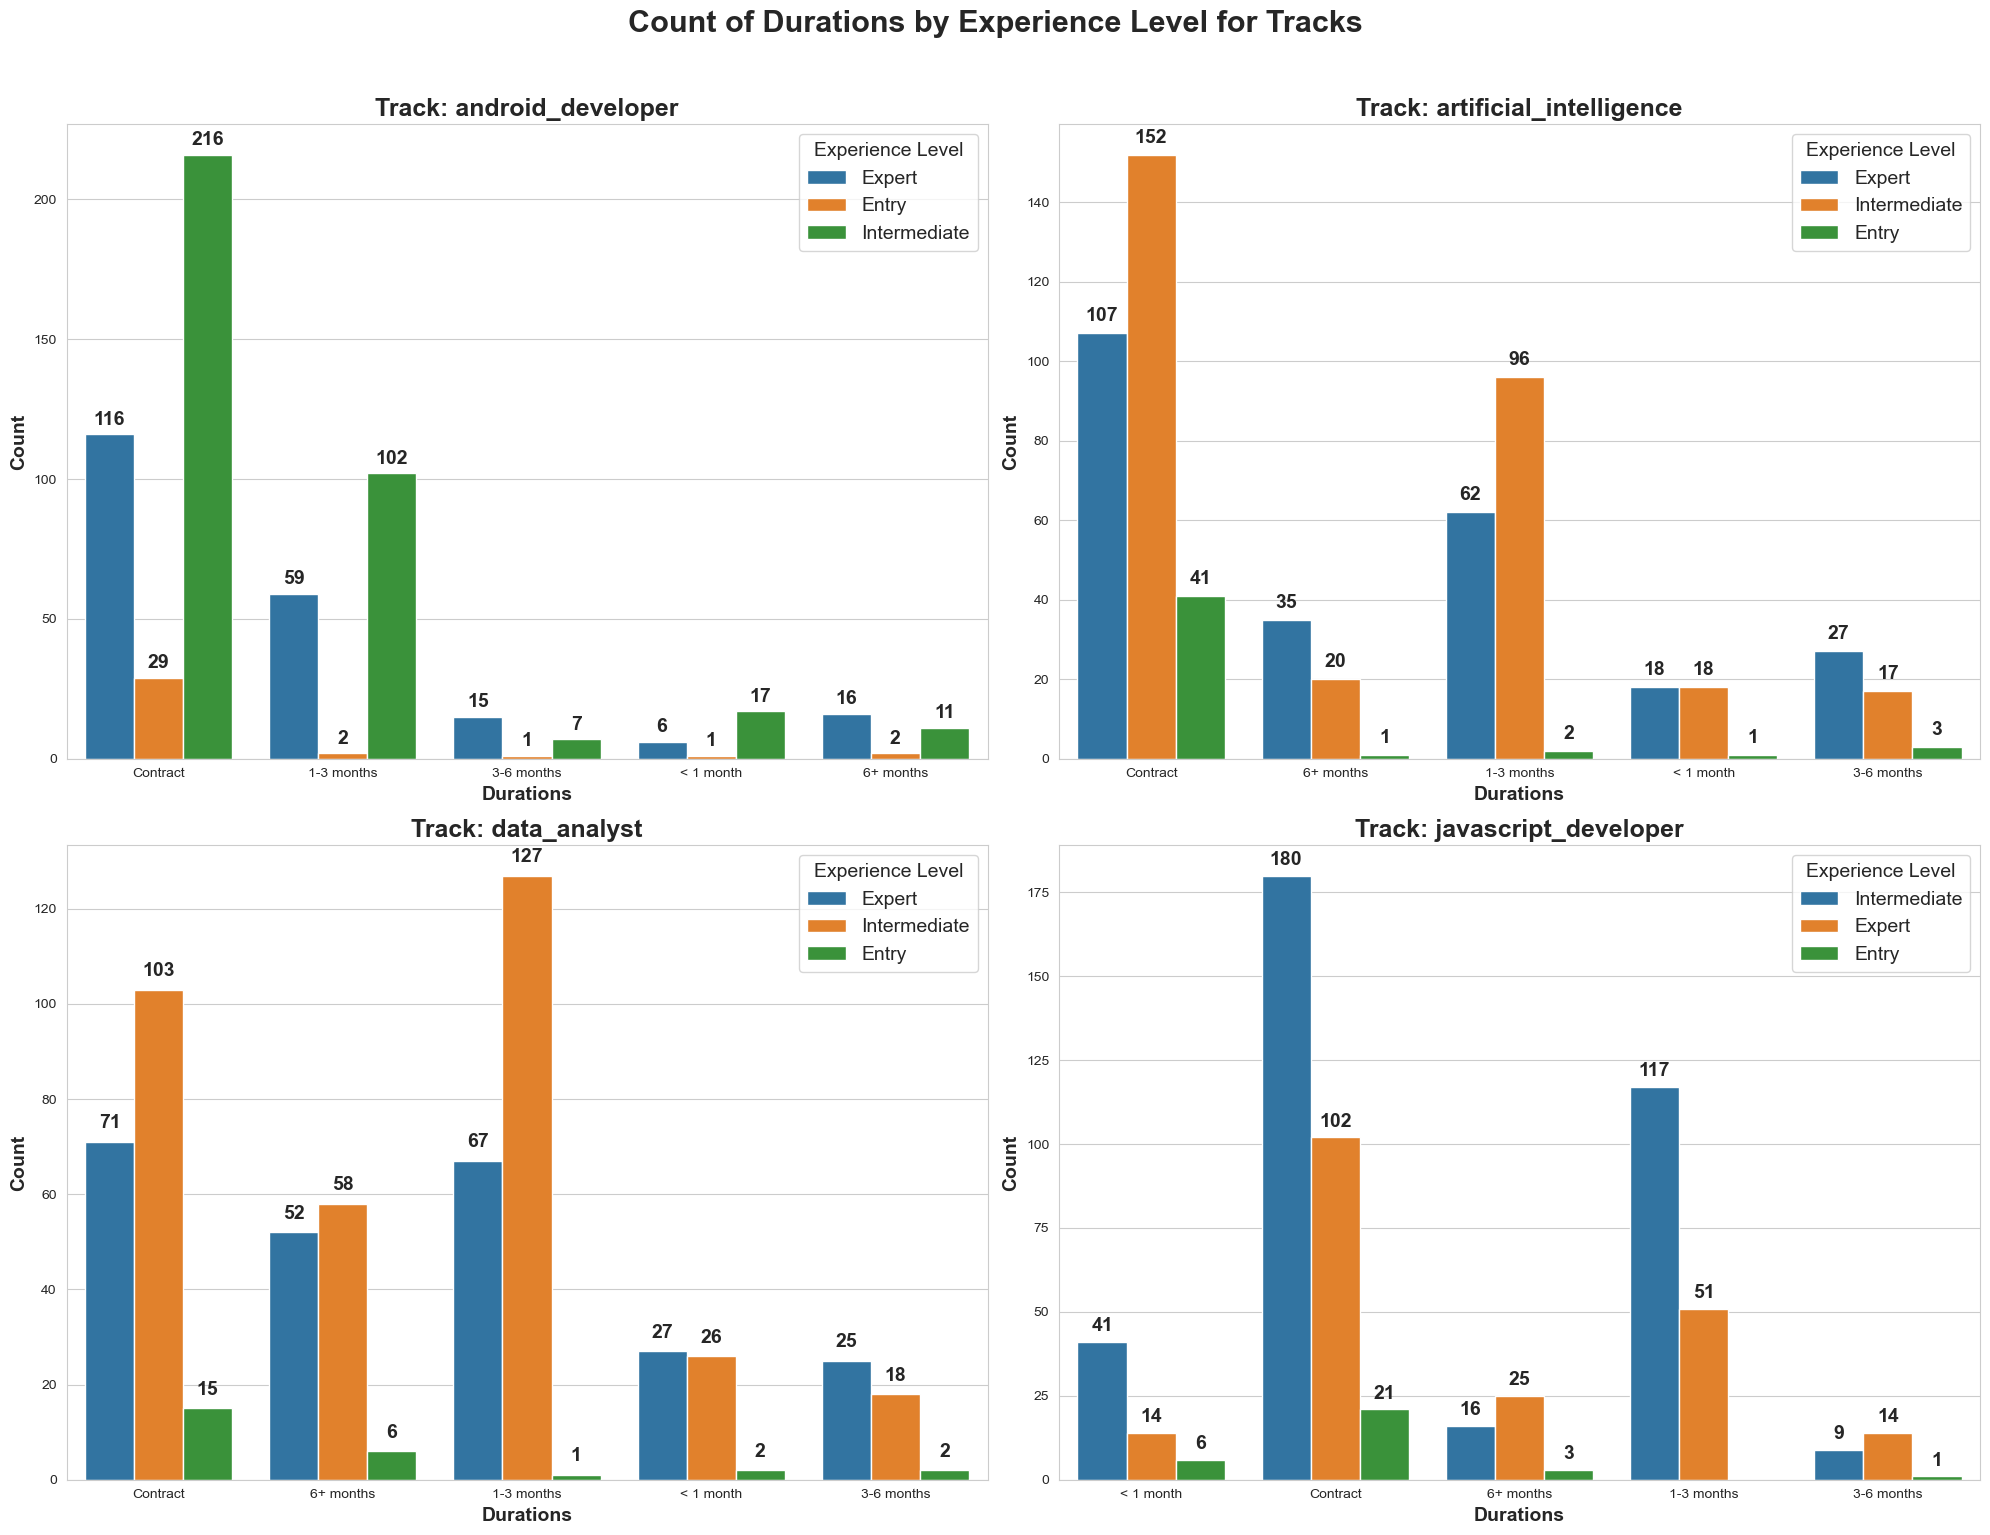

In [129]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Count of Durations by Experience Level for Tracks', fontsize=22, fontweight='bold', y=1.02)

track_names = df_after['track_name'].unique()

for ax, track in zip(axes.flat, track_names):
    # Plot countplot
    sns.countplot(data=df_after[df_after['track_name'] == track], x='duration', hue='experience_level', ax=ax)

    # Increase font size
    ax.set_title(f'Track: {track}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Durations', fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=14, fontweight='bold')
    
    # Add count labels above bars
    for p in ax.patches:
        if p.get_height() > 0:  # Avoid adding labels for zero values
            ax.text(p.get_x() + p.get_width() / 2,  
                    p.get_height() + 2,  # Offset to prevent overlap
                    int(p.get_height()),  
                    ha='center', va='bottom', fontsize=14, fontweight='bold')

    # Improve legend
    ax.legend(title="Experience Level", fontsize=14, title_fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


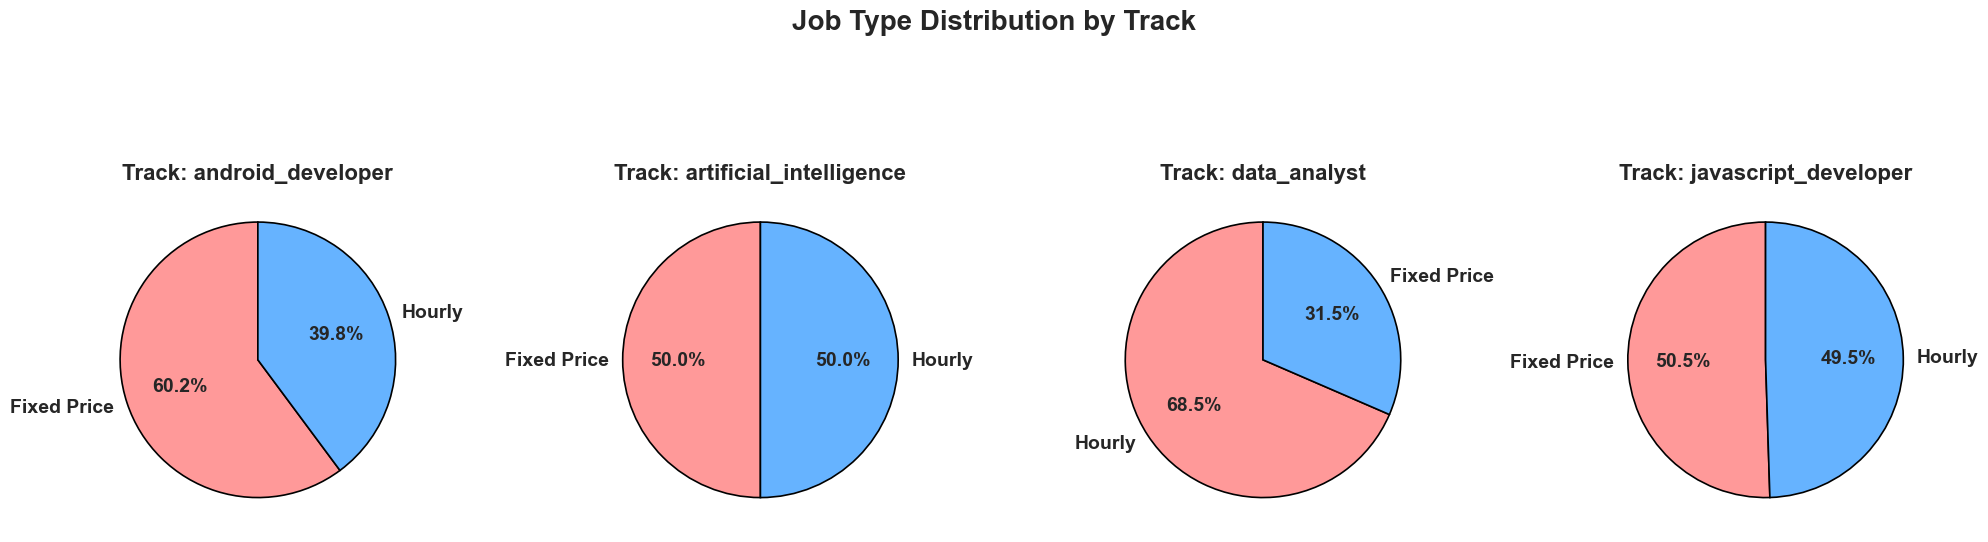

In [133]:
# Get unique track names
track_names = df_after['track_name'].unique()

# Create subplots
fig, axes = plt.subplots(1, len(track_names), figsize=(20, 6))

# If there's only one track, convert axes to an iterable list
if len(track_names) == 1:
    axes = [axes]

# Loop through each track and create a pie chart
for ax, track in zip(axes, track_names):
    # Get value counts for job_type in the current track
    job_counts = df_after[df_after['track_name'] == track]['job_type'].value_counts()

    # Plot pie chart
    ax.pie(job_counts, labels=job_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90, 
           wedgeprops={'edgecolor': 'black', 'linewidth': 1.2}, textprops={'fontsize': 14, 'fontweight': 'bold'})
    
    # Set title
    ax.set_title(f'Track: {track}', fontsize=16, fontweight='bold')

# Set overall title
plt.suptitle('Job Type Distribution by Track', fontsize=20, fontweight='bold', y=1.05)

# Show the plots
plt.tight_layout()
plt.show()


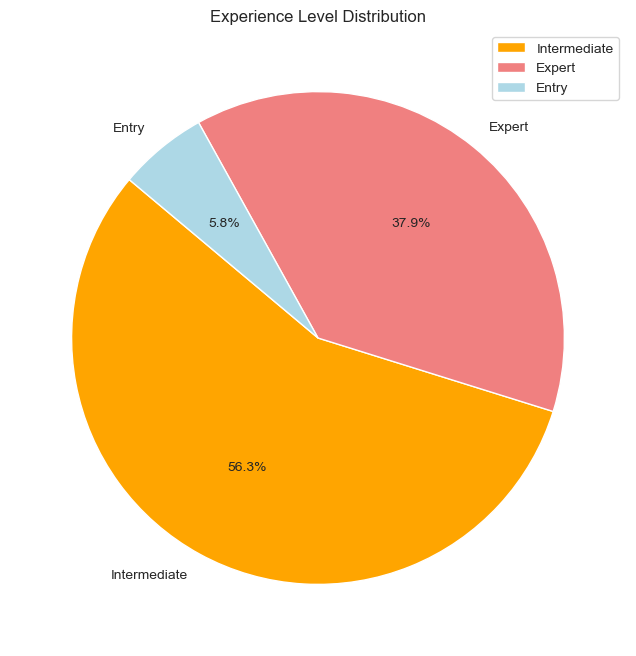

In [134]:
# Count the occurrences of each experience level
experience_counts = df_after['experience_level'].value_counts()

# Define colors for experience levels
color_map = {'Entry': 'lightblue', 'Intermediate': 'orange', 'Expert': 'lightcoral'}  

# Ensure labels are sorted properly
ordered_labels = experience_counts.index.tolist()

# Get colors based on the actual experience level names
colors = [color_map[label] for label in ordered_labels]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(experience_counts, labels=ordered_labels, autopct='%1.1f%%', colors=colors, startangle=140)

# Add legend with proper labels
plt.legend(ordered_labels, loc="best")

# Title
plt.title("Experience Level Distribution")

# Show the plot
plt.show()


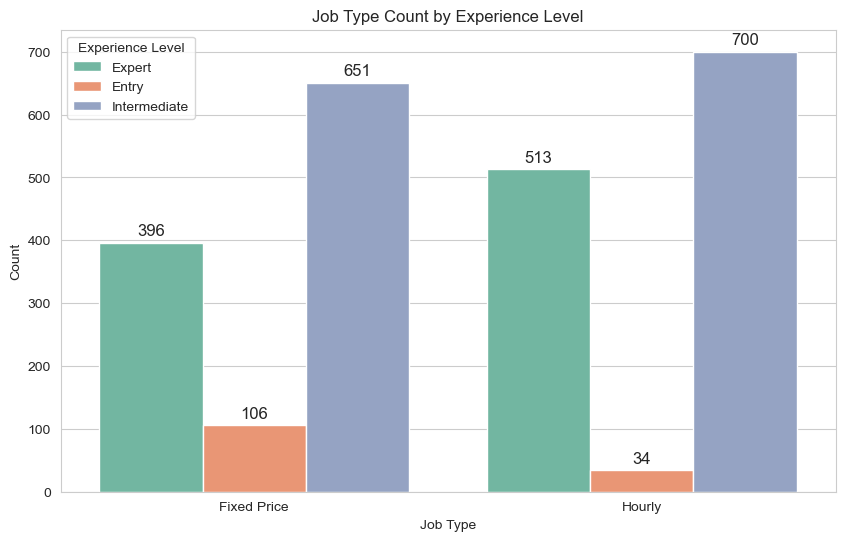

In [136]:

plt.figure(figsize=(10, 6))

# Create the bar plot
ax = sns.countplot(data=df_after, x='job_type', hue='experience_level', palette='Set2')

# Add count labels above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)

# Labels and title
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.title("Job Type Count by Experience Level")

# Show legend
plt.legend(title="Experience Level")

# Display the plot
plt.show()


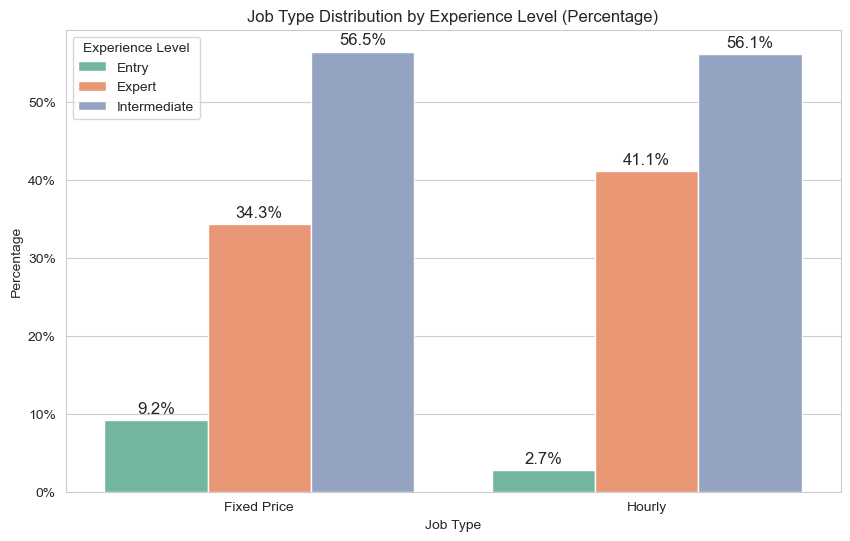

In [138]:
import matplotlib.ticker as mticker

# Compute counts
job_exp_counts = df_after.groupby(['job_type', 'experience_level']).size().reset_index(name='count')

# Compute percentages
total_counts = job_exp_counts.groupby('job_type')['count'].transform('sum')
job_exp_counts['percentage'] = (job_exp_counts['count'] / total_counts) * 100

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=job_exp_counts, x='job_type', y='percentage', hue='experience_level', palette='Set2')

# Add percentage labels above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=12, label_type='edge', padding=3)

# Format Y-axis as percentage
ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Labels and title
plt.xlabel("Job Type")
plt.ylabel("Percentage")
plt.title("Job Type Distribution by Experience Level (Percentage)")
plt.legend(title="Experience Level")

# Show the plot
plt.show()


- top 20 most skill by track, all tracks

In [140]:
import ast
from collections import Counter

df_skills = df_after['skills'].apply(ast.literal_eval) 
all_skills = [skill for skills_list in df_skills for skill in skills_list]
skill_counts = Counter(all_skills)
skill_counts_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

print(skill_counts_df)


                                                  Skill  Count
4                                                Python    813
2                                            JavaScript    765
20                                              Android    600
15                                                  iOS    585
6                                       Web Development    528
16                                           Smartphone    493
194                             Artificial Intelligence    423
3                                                   PHP    407
18                               Mobile App Development    357
35                                                  API    357
493                                     Microsoft Excel    350
418                                       Data Analysis    340
477                                        Data Science    336
8                                                  Java    295
39                                            WordPress

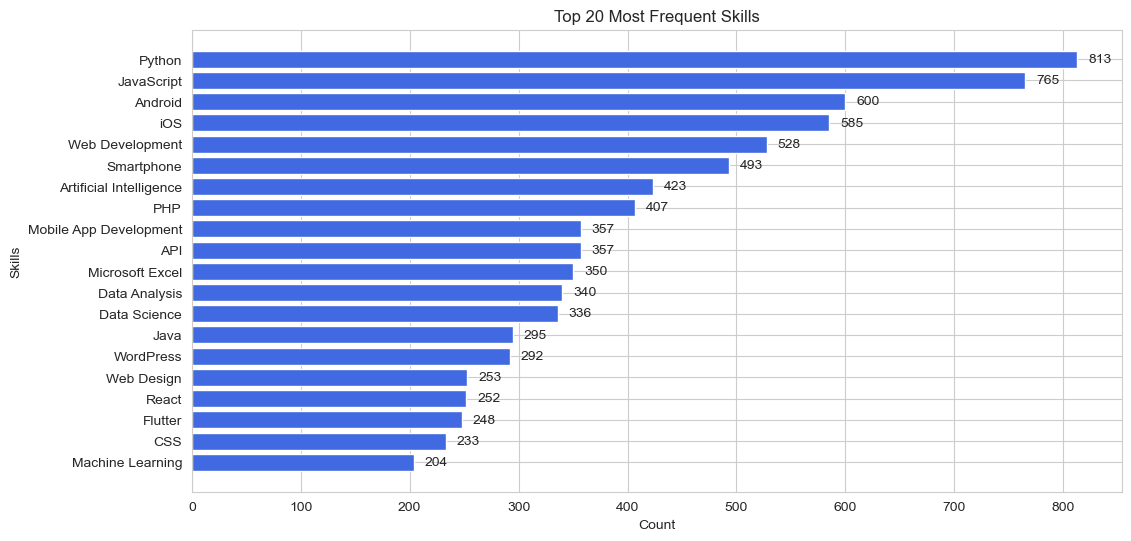

In [141]:
top_n = 20  
top_skills = skill_counts_df.head(top_n)
plt.figure(figsize=(12, 6))
bars = plt.barh(top_skills['Skill'], top_skills['Count'], color='royalblue')
for bar in bars:
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
             str(int(bar.get_width())),  
             va='center', ha='left', fontsize=10) 

plt.xlabel("Count")
plt.ylabel("Skills")
plt.title(f"Top {top_n} Most Frequent Skills")
plt.gca().invert_yaxis()  
plt.show()


In [142]:
import ast
import pandas as pd
from collections import Counter

# Ensure 'skills' column is properly converted to lists
df_after['skills'] = df_after['skills'].apply(ast.literal_eval)

# Explode the dataframe to have one skill per row
df_exploded = df_after.explode('skills')

# Count occurrences of each skill per track
skill_counts = df_exploded.groupby(['track_name', 'skills']).size().reset_index(name='Count')

# Sort values by track and count
skill_counts = skill_counts.sort_values(by=['track_name', 'Count'], ascending=[True, False])

print(skill_counts)


                   track_name  \
36          android_developer   
393         android_developer   
299         android_developer   
209         android_developer   
129         android_developer   
178         android_developer   
394         android_developer   
366         android_developer   
177         android_developer   
342         android_developer   
235         android_developer   
38          android_developer   
46          android_developer   
347         android_developer   
169         android_developer   
267         android_developer   
97          android_developer   
234         android_developer   
208         android_developer   
335         android_developer   
126         android_developer   
179         android_developer   
11          android_developer   
14          android_developer   
72          android_developer   
365         android_developer   
339         android_developer   
259         android_developer   
375         android_developer   
75        

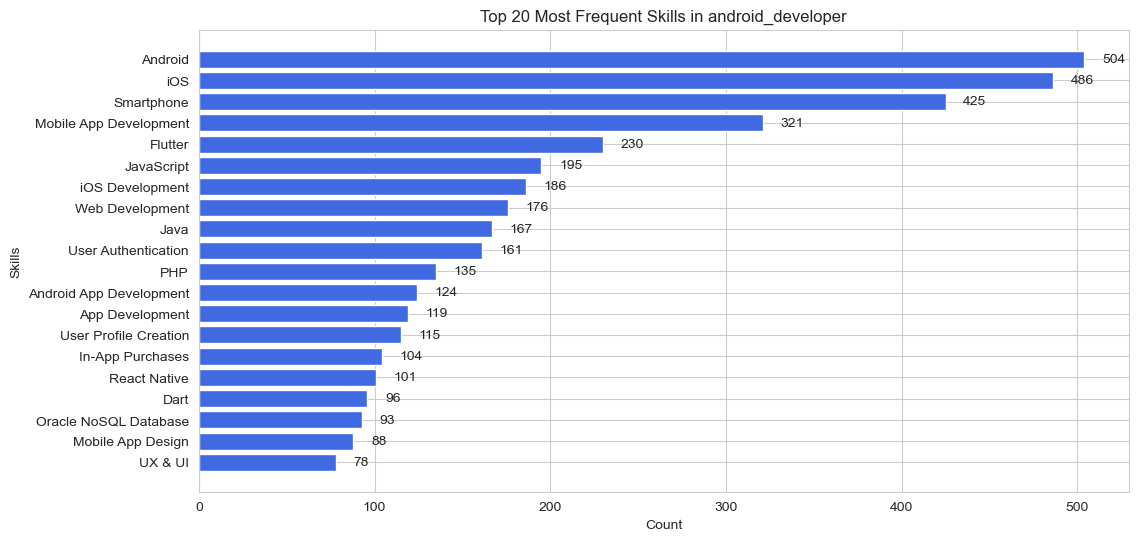

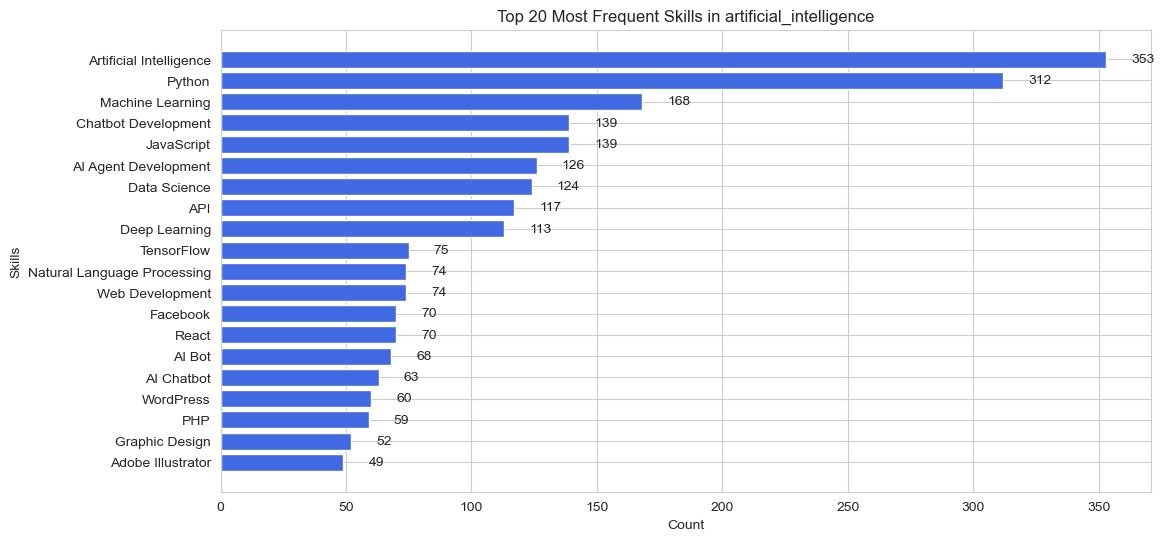

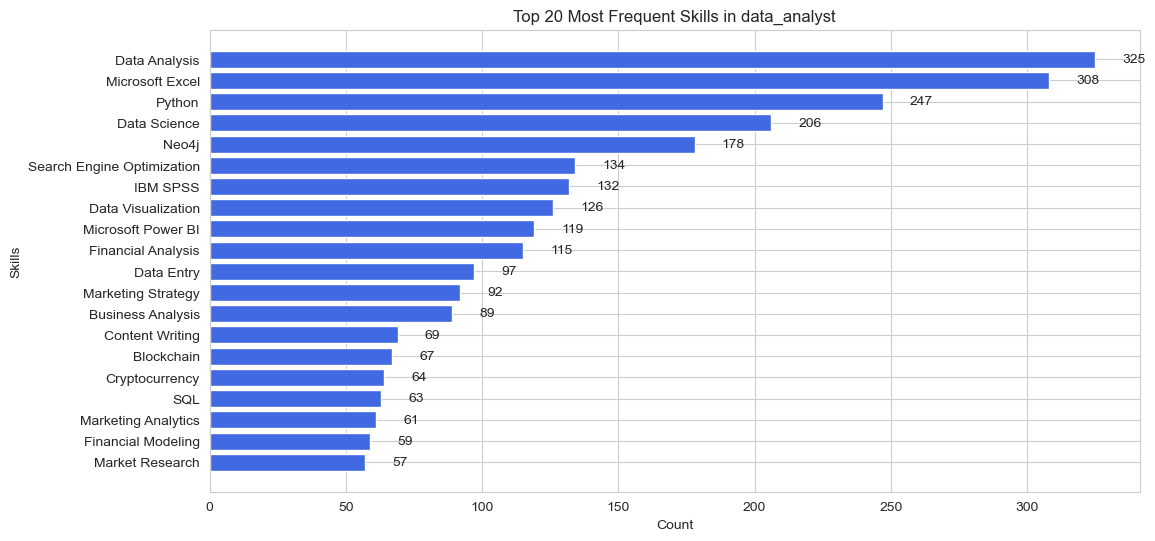

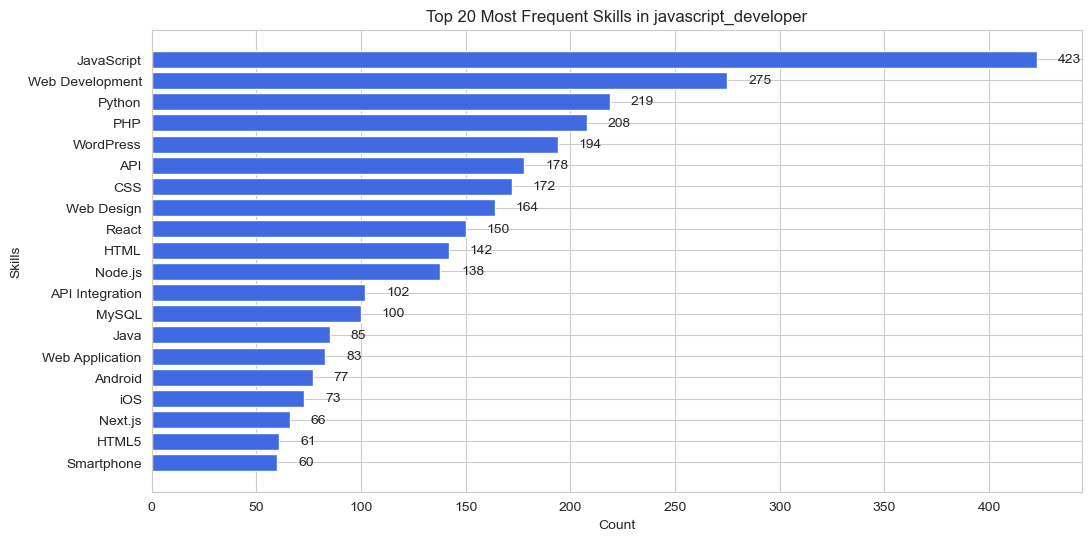

In [143]:
tracks = df_after['track_name'].unique()  # Extract unique track names
for track in tracks:
    
    track_to_plot = track 
    filtered_df = skill_counts[skill_counts['track_name'] == track_to_plot]

    top_n = 20  
    top_skills = filtered_df.head(top_n)

    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_skills['skills'], top_skills['Count'], color='royalblue')

    for bar in bars:
        plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
                str(int(bar.get_width())),  
                va='center', ha='left', fontsize=10) 

    plt.xlabel("Count")
    plt.ylabel("Skills")
    plt.title(f"Top {top_n} Most Frequent Skills in {track_to_plot}")
    plt.gca().invert_yaxis()
    plt.show()


- total spent in each track

In [144]:
track_spend = df_after.groupby('track_name')['client_total_spent'].sum().reset_index()


top_track = track_spend.sort_values(by='client_total_spent', ascending=False).iloc[0]

print(f"Track with the highest total spend: {top_track['track_name']} (${top_track['client_total_spent']:.2f})")


Track with the highest total spend: data_analyst ($46967339.00)


C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\3893899028.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




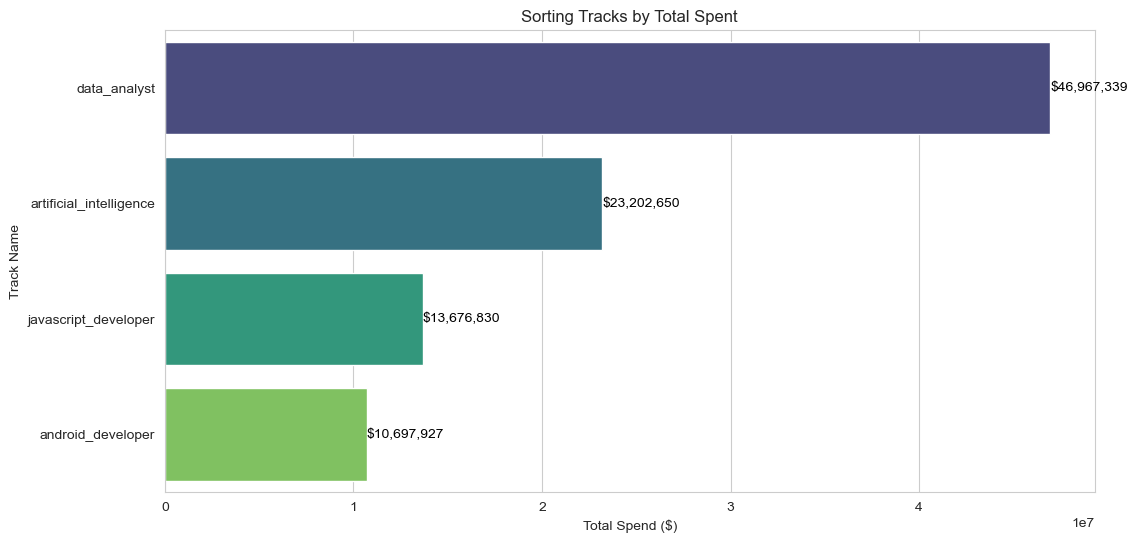

In [146]:
top_10_tracks = track_spend.sort_values(by='client_total_spent', ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_tracks, x='client_total_spent', y='track_name', palette='viridis')
for index, value in enumerate(top_10_tracks['client_total_spent']):
    ax.text(value, index, f"${value:,.0f}", va='center', fontsize=10, color='black')

plt.xlabel('Total Spend ($)')
plt.ylabel('Track Name')
plt.title('Sorting Tracks by Total Spent')
plt.show()


- job with hires and active (by track) (Hend)

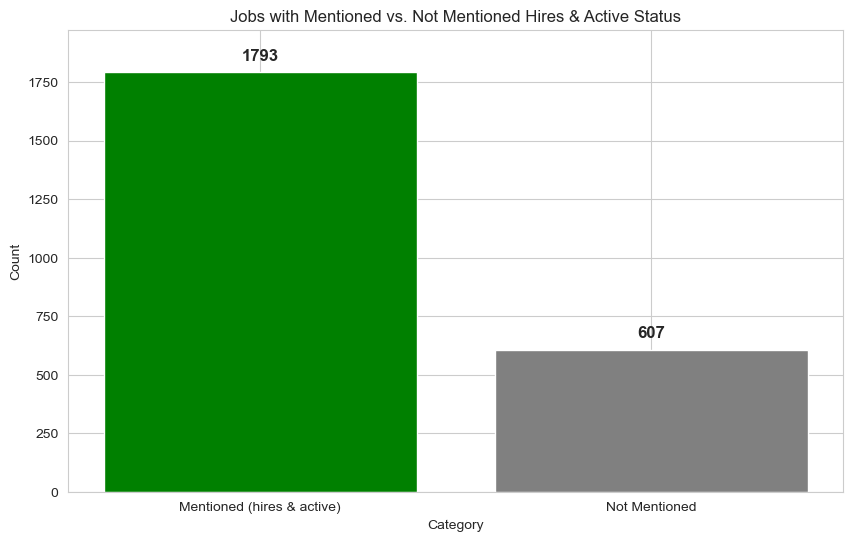

In [148]:

total_entries = df_after.shape[0]  # Total rows in DataFrame
specified_count = df_after[['hires', 'active']].notna().all(axis=1).sum()  # Count rows where both 'hires' and 'active' are not NaN
unspecified_count = total_entries - specified_count  # Remaining rows
plt.figure(figsize=(10, 6))
bars = plt.bar(['Mentioned (hires & active)', 'Not Mentioned'], [specified_count, unspecified_count], color=['green', 'gray'])
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(int(bar.get_height())), ha='center', fontsize=12, fontweight='bold')

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Jobs with Mentioned vs. Not Mentioned Hires & Active Status")
plt.ylim(0, max(specified_count, unspecified_count) * 1.1) 
plt.show()


- avg of avg budget (hourly and fixed) (Hend)

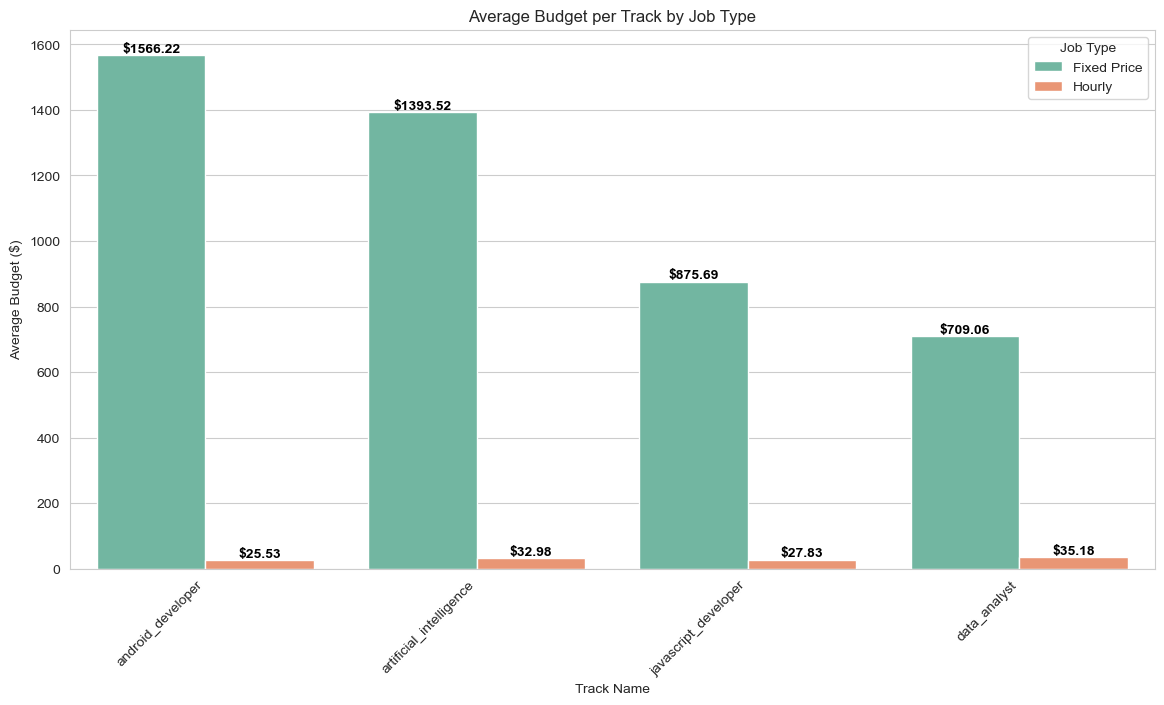

In [150]:

# Compute average budget for each track and job type
df_sorted = df_after.groupby(['track_name', 'job_type'], as_index=False)['average_budget'].mean()

# Sort tracks by overall average budget
track_order = df_sorted.groupby('track_name')['average_budget'].mean().sort_values(ascending=False).index
df_sorted['track_name'] = pd.Categorical(df_sorted['track_name'], categories=track_order, ordered=True)

# Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df_sorted, x='track_name', y='average_budget', hue='job_type', palette='Set2')

# Add labels above bars
for p in ax.patches:
    if p.get_height() > 0:  # Skip annotation for zero-height bars
        ax.annotate(f'${p.get_height():.2f}',  
                    (p.get_x() + p.get_width() / 2, p.get_height()),  
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.xlabel("Track Name")
plt.ylabel("Average Budget ($)")
plt.title("Average Budget per Track by Job Type")
plt.legend(title="Job Type")

plt.show()


- count diff proposals

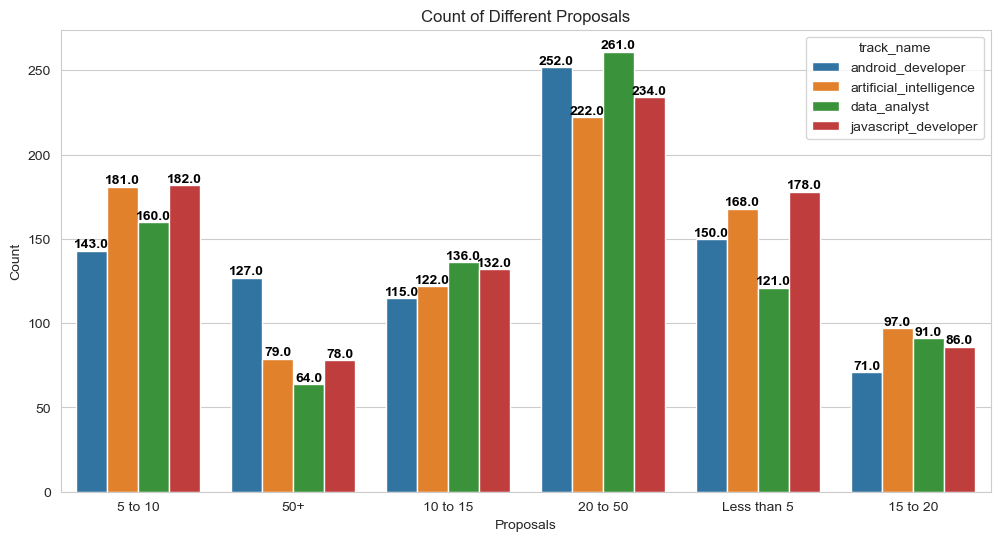

In [154]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='proposals', hue='track_name')

# Add count labels above each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid placing labels on bars with zero count
        ax.annotate(f'{height}',  
                    (p.get_x() + p.get_width() / 2, height),  
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.title('Count of Different Proposals')
plt.xlabel('Proposals')
plt.ylabel('Count')

# Show plot
plt.show()


In [155]:
fig = px.histogram(
    df_after, 
    x="client_total_spent", 
    nbins=50,  # Adjust the number of bins as needed
    opacity=0.75,
    histnorm="density",  # Normalized histogram (optional)
)

fig.update_layout(
    title="Distribution of Client Total Spent",
    xaxis_title="Client Total Spent",
    yaxis_title="Density",
    bargap=0.1,  # Space between bars
)

fig.show()


- count of clients by loc

C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\2181748521.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




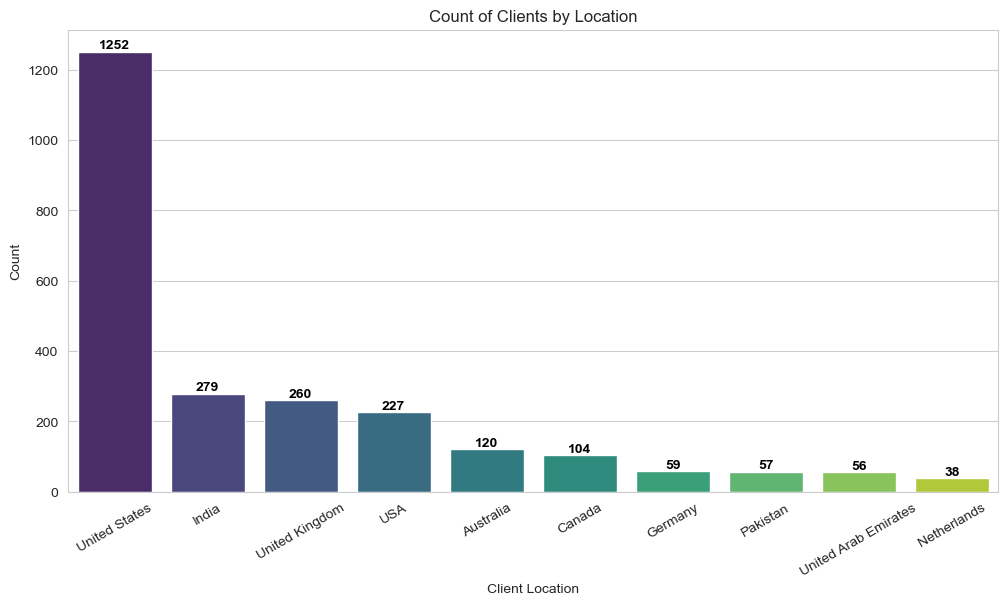

In [156]:
plt.figure(figsize=(12, 6))

# Get top 10 client locations and reset index
d = df['client_location'].value_counts().head(10).reset_index()
d.columns = ['client_location', 'count']  # Rename columns for clarity

# Create bar plot
ax = sns.barplot(data=d, x='client_location', y='count', palette='viridis')

# Add count labels above each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid placing labels on zero-height bars
        ax.annotate(f'{int(height)}',  
                    (p.get_x() + p.get_width() / 2, height),  
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.title('Count of Clients by Location')
plt.xlabel('Client Location')
plt.ylabel('Count')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=30)

# Show plot
plt.show()


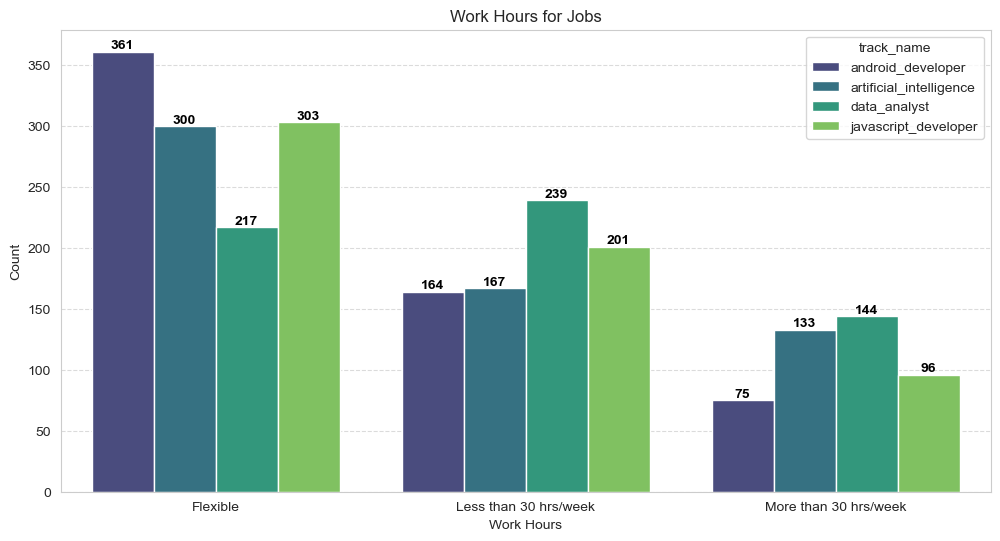

In [158]:

plt.figure(figsize=(12, 6))

# Create count plot
ax = sns.countplot(data=df_after, x='work_hours', hue='track_name', palette="viridis")

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.title('Work Hours for Jobs')
plt.xlabel('Work Hours')
plt.ylabel('Count')

# Enable grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


- avg budget distribution

In [160]:
hourly_average_budget = df_after[df_after['job_type'] == 'Hourly']
fixed_price_average_budget = df_after[df_after['job_type'] == 'Fixed Price']

In [161]:
hourly_average_budget.average_budget.value_counts().sort_index(ascending=False)

average_budget
503.500      2
200.000      2
175.000      1
167.500      1
150.000      2
135.300      1
125.000      5
120.000      1
115.000      2
112.500      1
110.000      1
107.500      1
105.000      1
102.500      1
100.000      4
95.000       2
90.000       2
87.500       3
86.875       1
85.000       2
82.500       1
78.000       2
77.500       2
75.000      14
72.500       4
70.000       6
67.500       4
65.000      13
62.500       3
60.500       1
60.000       9
59.500       1
57.500      10
56.000       1
55.000      18
52.500       6
51.500       1
50.000      18
49.500       2
47.500       9
47.000       1
46.500       1
45.000      55
44.500       5
43.000       1
42.500      14
42.000       1
41.500       1
40.000      25
39.500       3
39.000       3
38.500       1
38.000       4
37.500      28
37.000       1
36.500       4
36.000      21
35.000      34
34.500       5
34.000       3
33.500       1
32.500      80
32.000       1
31.500       5
31.000       3
30.000    

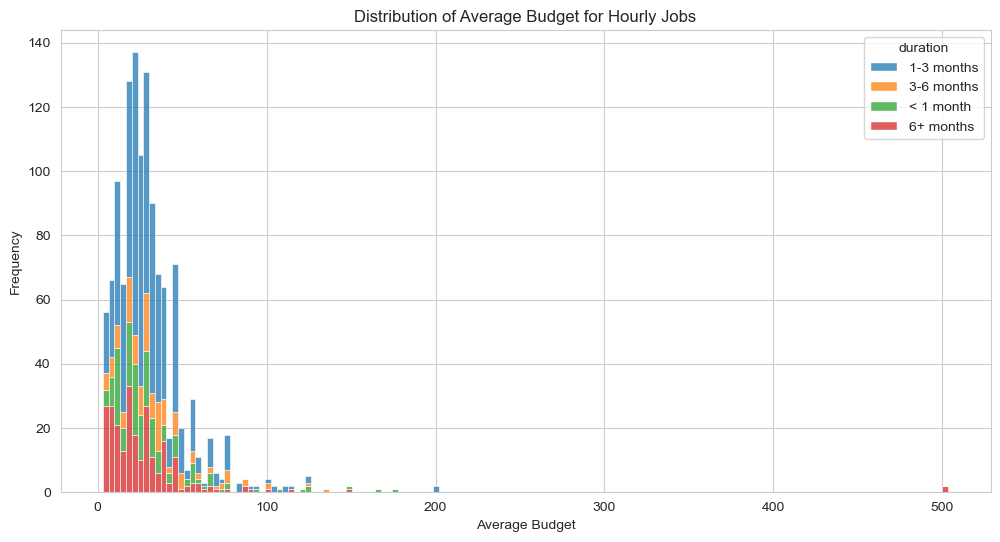

In [162]:
plt.figure(figsize=(12, 6))
sns.histplot(data=hourly_average_budget, x='average_budget', hue='duration', multiple="stack")
plt.title('Distribution of Average Budget for Hourly Jobs')
plt.xlabel('Average Budget')
plt.ylabel('Frequency')
plt.show()

- avg budget distribution and duration

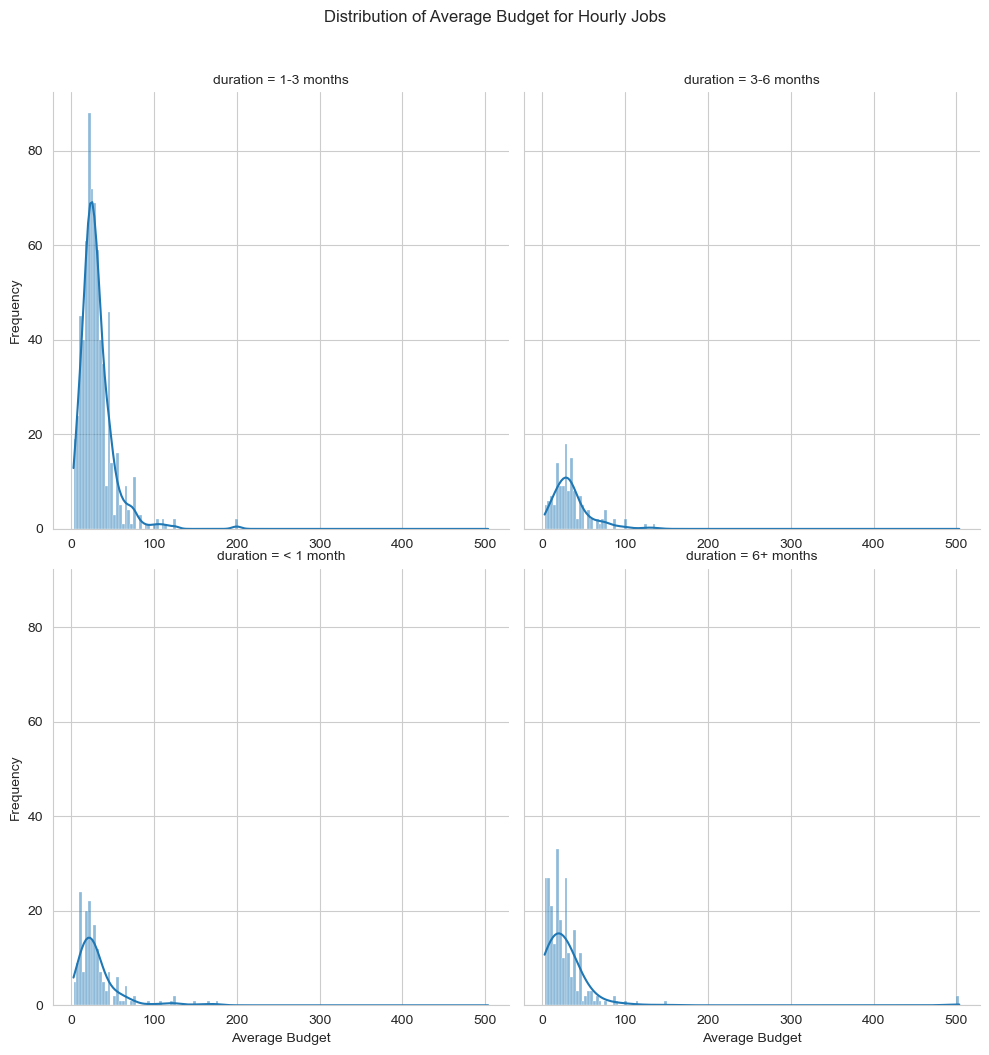

In [163]:
g = sns.displot(data=hourly_average_budget, x='average_budget', col='duration', kde=True, col_wrap=2)
g.figure.suptitle('Distribution of Average Budget for Hourly Jobs', y=1.05)
g.set_axis_labels("Average Budget", "Frequency")
for ax in g.axes.flat:
    ax.tick_params(axis='x', which='both', labelbottom=True)
plt.show()

- fixed price

In [164]:
# Create the histogram using Plotly
fig = px.histogram(
    fixed_price_average_budget, 
    x="average_budget", 
    color="duration",  # Equivalent to hue in Seaborn
    title="Average Budget Distribution",
    labels={"average_budget": "Average Budget", "duration": "Duration"},
    barmode="overlay",  # Adjust bar mode (overlay/stack)
)

# Show the plot
fig.show()


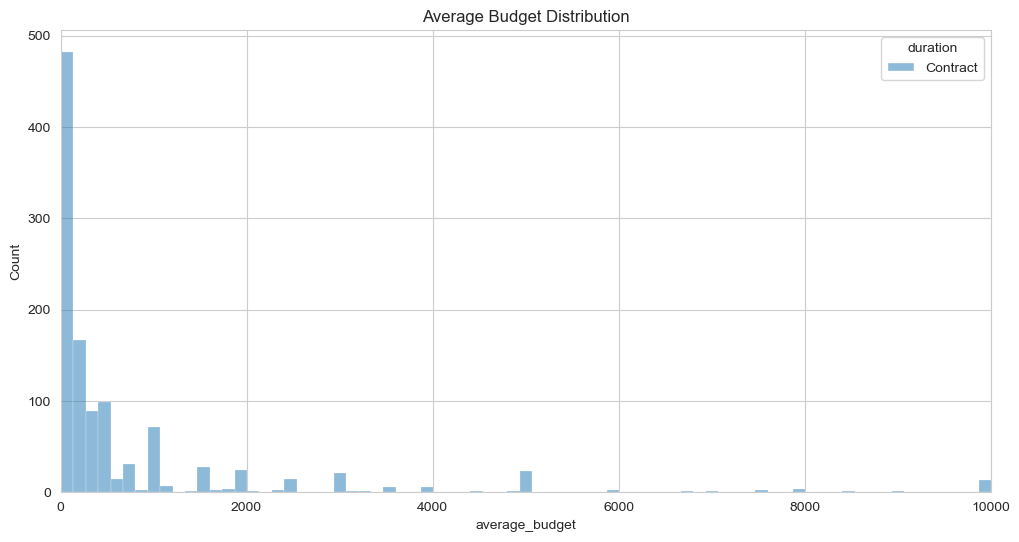

In [165]:
plt.figure(figsize=(12, 6))
sns.histplot(data=fixed_price_average_budget, x='average_budget', hue='duration')
plt.title('Average Budget Distribution')
plt.xlim(0,10000)
plt.show()

- correlation

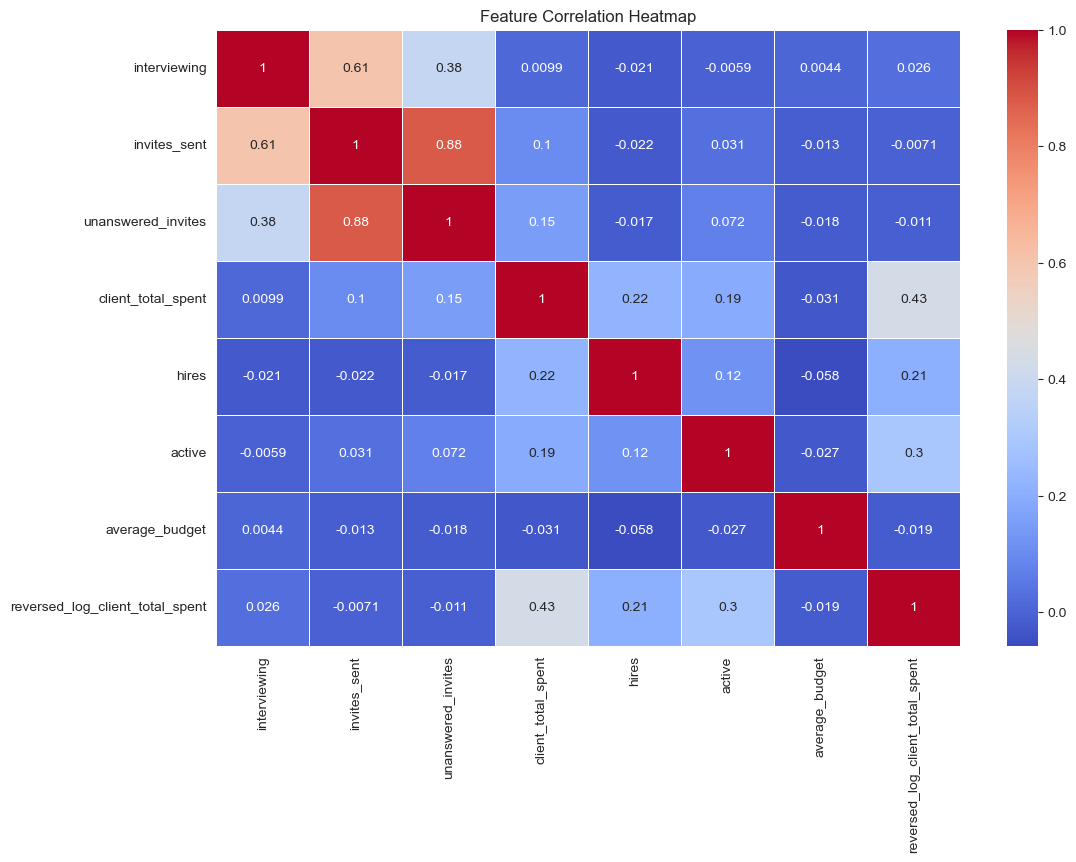

In [166]:
numeric_df = df_after.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

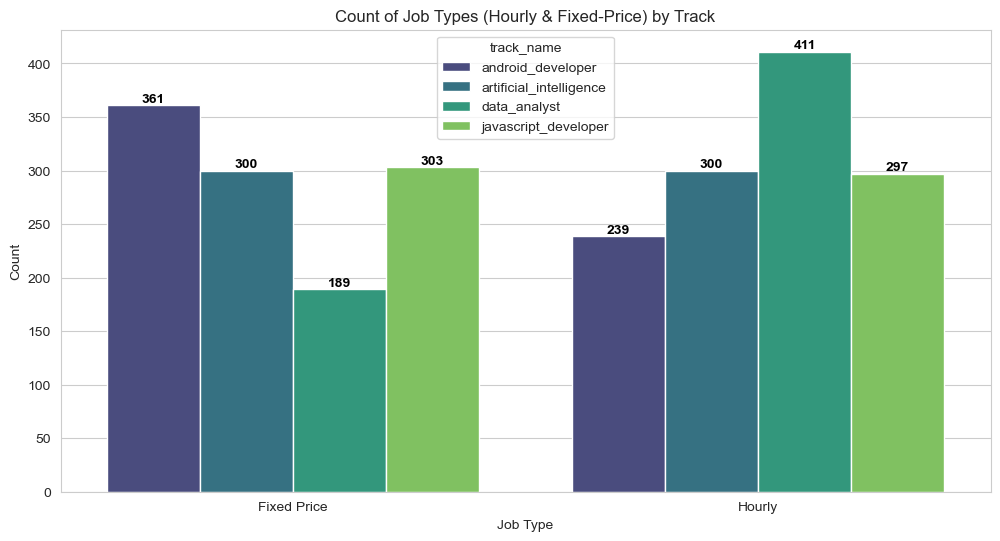

In [168]:


plt.figure(figsize=(12, 6))

# Create count plot
ax = sns.countplot(data=df_after, x='job_type', hue='track_name', palette="viridis")

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.title('Count of Job Types (Hourly & Fixed-Price) by Track')
plt.xlabel('Job Type')
plt.ylabel('Count')

# Show plot
plt.show()


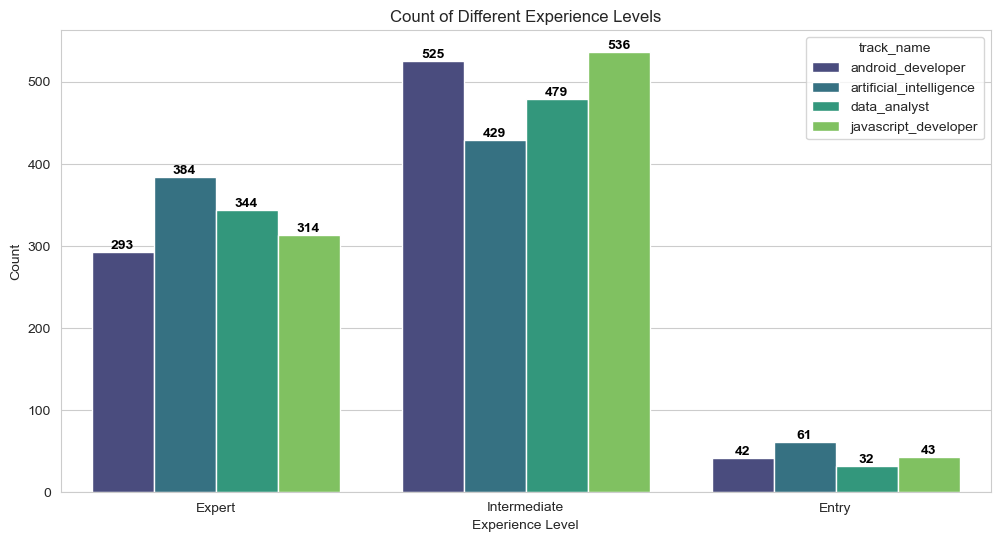

In [169]:

plt.figure(figsize=(12, 6))

# Create count plot
ax = sns.countplot(data=df, x='experience_level', hue='track_name', palette="viridis")

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.title('Count of Different Experience Levels')
plt.xlabel('Experience Level')
plt.ylabel('Count')

# Show plot
plt.show()


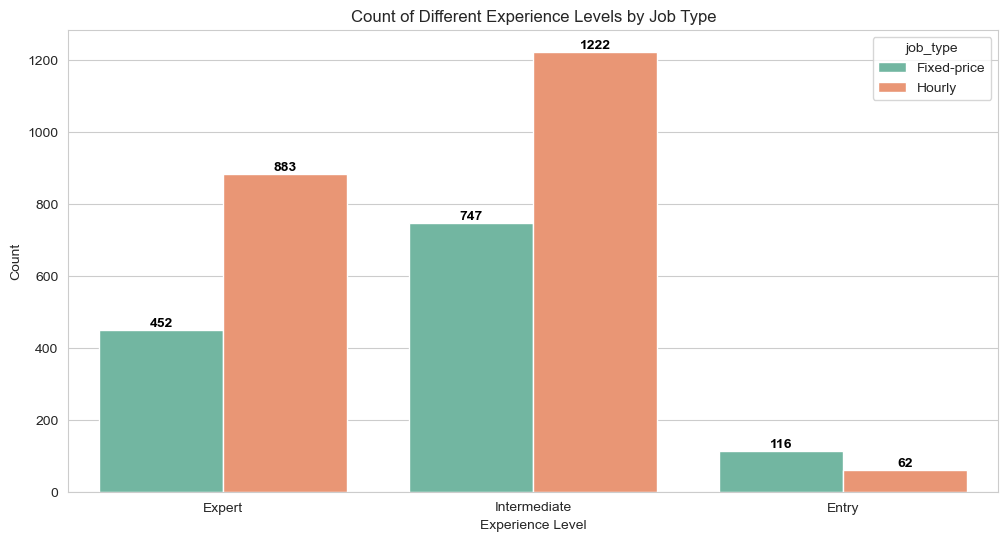

In [170]:
plt.figure(figsize=(12, 6))

# Create count plot
ax = sns.countplot(data=df, x='experience_level', hue='job_type', palette="Set2")

# Add count labels above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.title('Count of Different Experience Levels by Job Type')
plt.xlabel('Experience Level')
plt.ylabel('Count')

# Show plot
plt.show()


In [171]:
fig = px.histogram(
    df_after, 
    x="client_total_spent", 
    nbins=50,  # Adjust the number of bins as needed
    opacity=0.75,
    histnorm="density",  # Normalized histogram (optional)
)

fig.update_layout(
    title="Distribution of Client Total Spent",
    xaxis_title="Client Total Spent",
    yaxis_title="Density",
    bargap=0.1,  # Space between bars
)

fig.show()


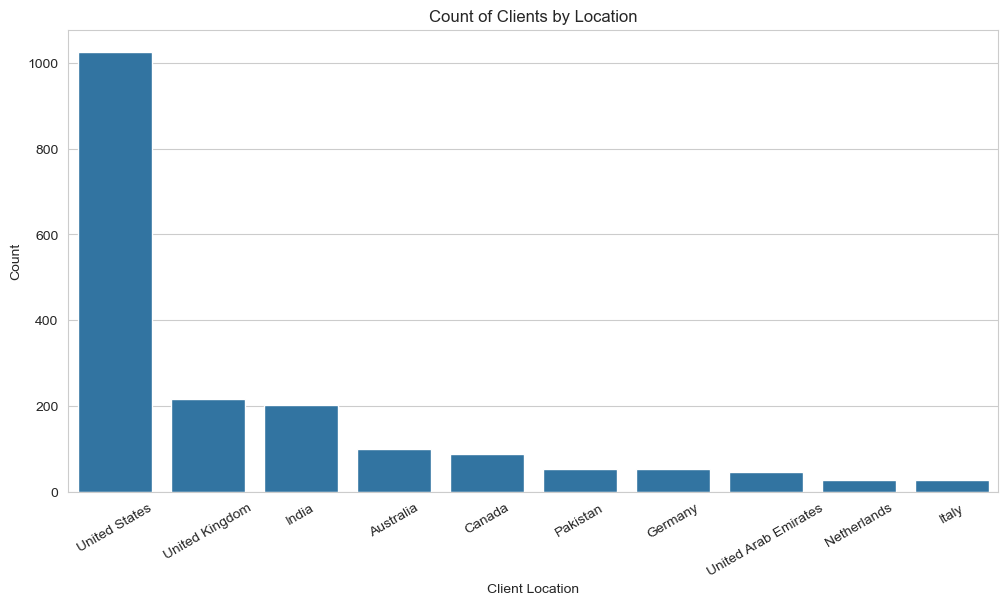

In [172]:
plt.figure(figsize=(12, 6))
d = df_after['client_location'].value_counts().head(10)
sns.barplot(data=d)
plt.title('Count of Clients by Location')
plt.xlabel('Client Location')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\1816138797.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\1816138797.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\1816138797.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\1816138797.py:22: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Hend-PC\AppData\Local\Temp\ipykernel_9052\1816138797.py:15: FutureWarning:



Passing

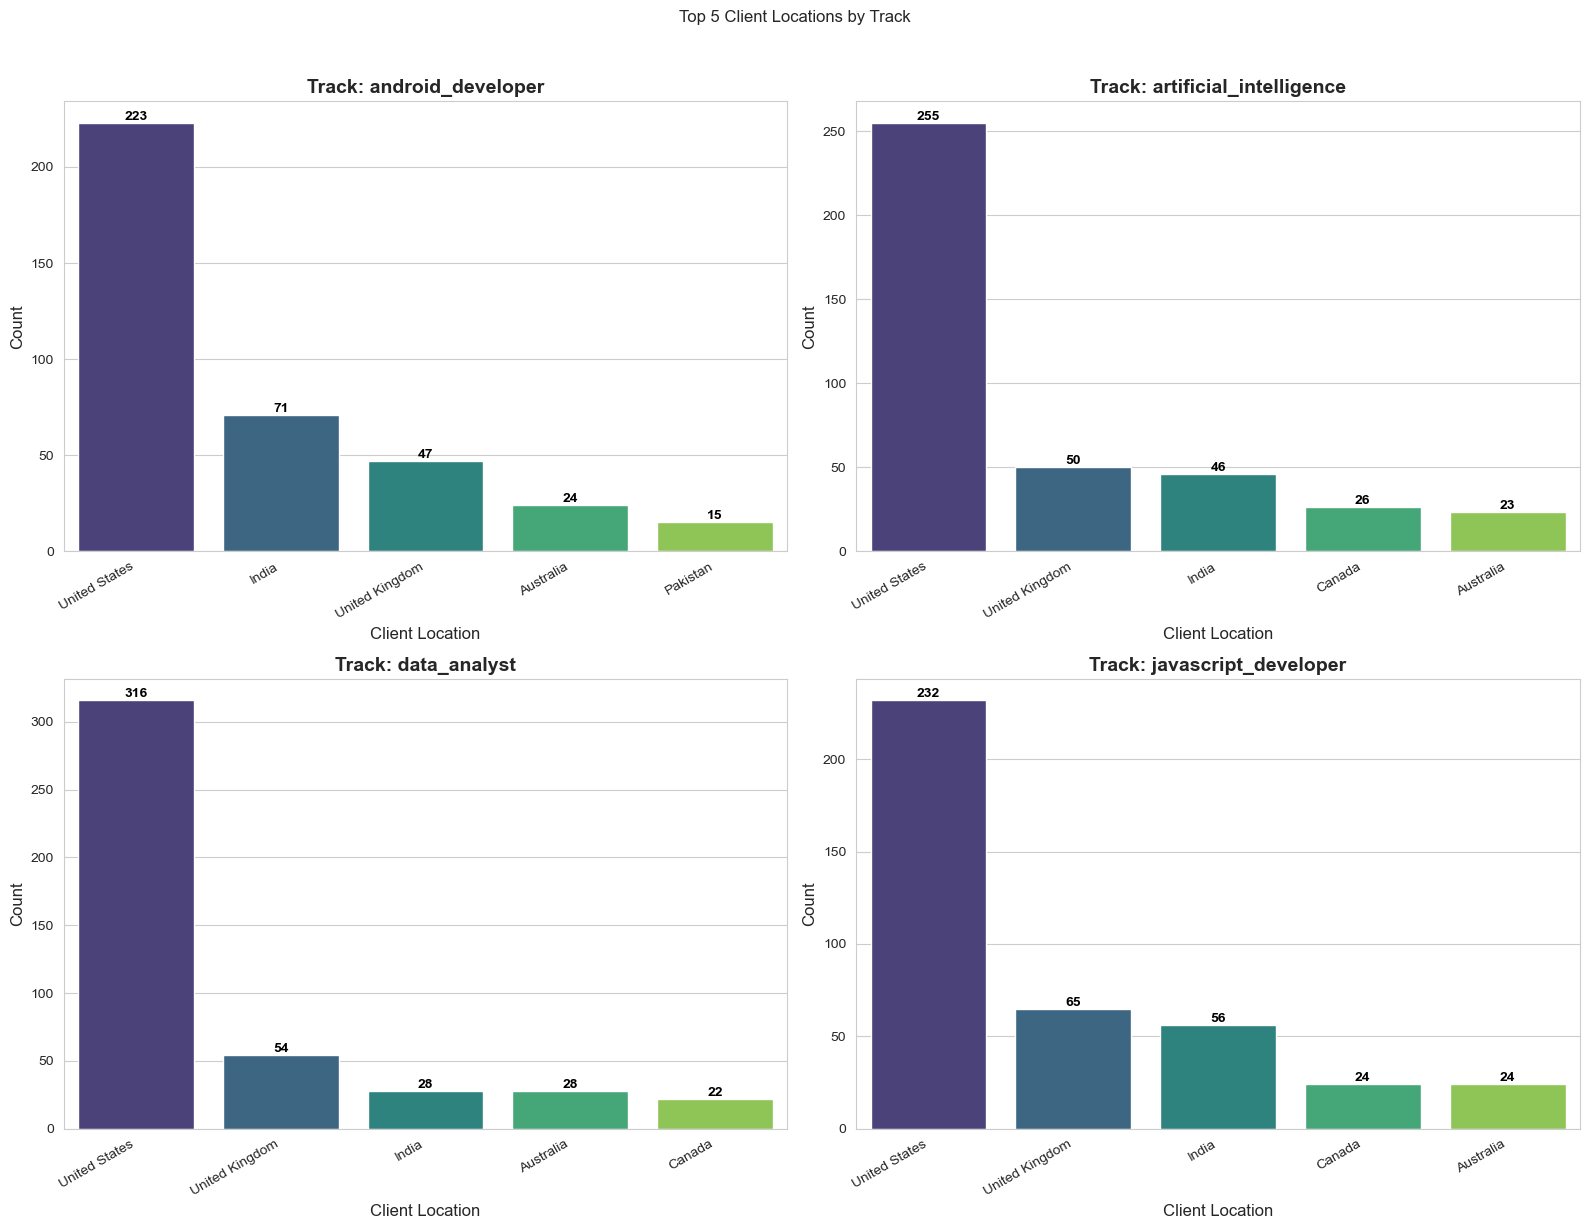

In [175]:

# Set figure size and layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2 rows, 2 columns
fig.suptitle('Top 5 Client Locations by Track', y=1.02)

# Get unique track names
track_names = df_after['track_name'].unique()

# Loop through each track and plot on corresponding subplot
for ax, track in zip(axes.flat, track_names):
    # Get top 5 client locations for this track
    d = df_after[df_after['track_name'] == track]['client_location'].value_counts().head(5).reset_index()
    d.columns = ['client_location', 'count']

    # Plot the bar chart
    sns.barplot(data=d, x='client_location', y='count', ax=ax, palette="viridis")

    ax.set_title(f'Track: {track}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Client Location', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

    # Rotate x-axis labels for better visibility
    ax.set_xticklabels(d['client_location'], rotation=30, ha='right')

    # Add count labels above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold', color='black')

# Adjust layout
plt.tight_layout()
plt.show()


In [179]:
df = pd.read_csv("Upwork_Scrapped_Dataset_After_Preprocessing_Without_Encoding.csv")

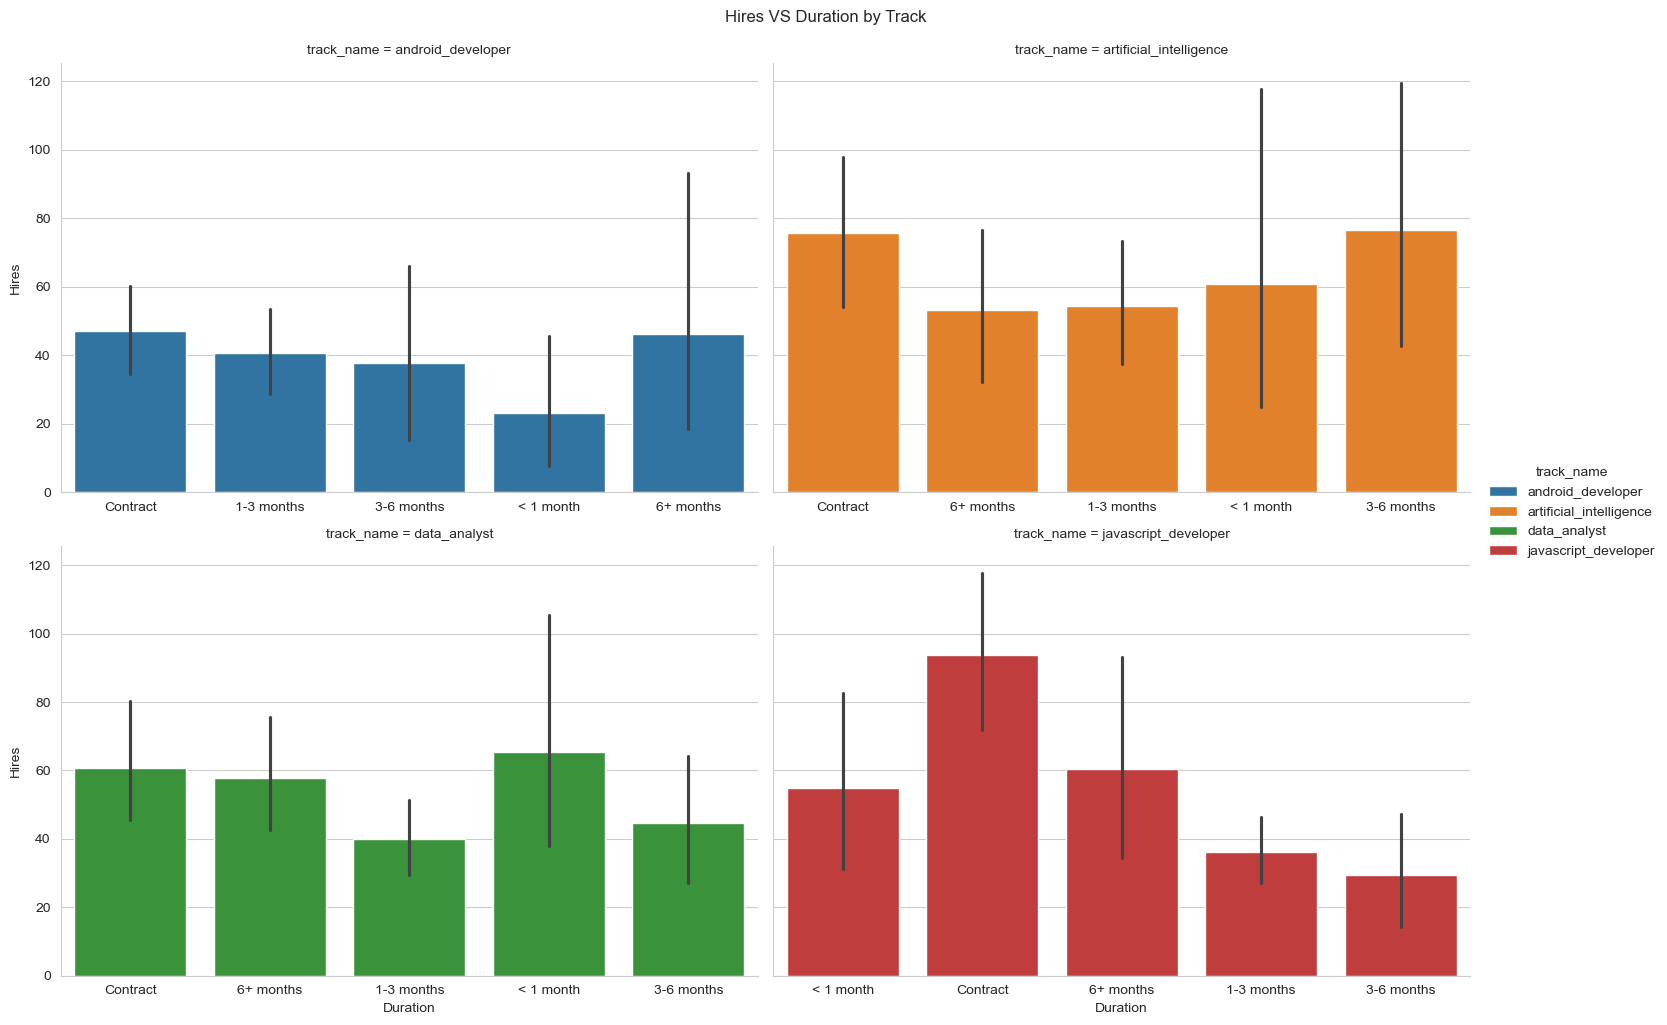

In [181]:
hourly_average_budget = df[df['job_type'] == 'Hourly']
fixed_price_average_budget = df[df['job_type'] == 'Fixed Price']
log_client_total_spent = np.log(df.client_total_spent)
log_average_budget = np.log(df.average_budget)
g = sns.catplot(
    data=df,
    x="duration", 
    y="hires", 
    hue="track_name", 
    kind="bar", 
    col="track_name",  # Ensure subplots are created per track
    col_wrap=2,        # Wrap into two columns
    height=5,
    aspect=1.5,
    sharex=False
)

# Add a common title
g.figure.suptitle("Hires VS Duration by Track", y=1.02)

# Set axis labels
g.set_axis_labels("Duration", "Hires")

plt.show()


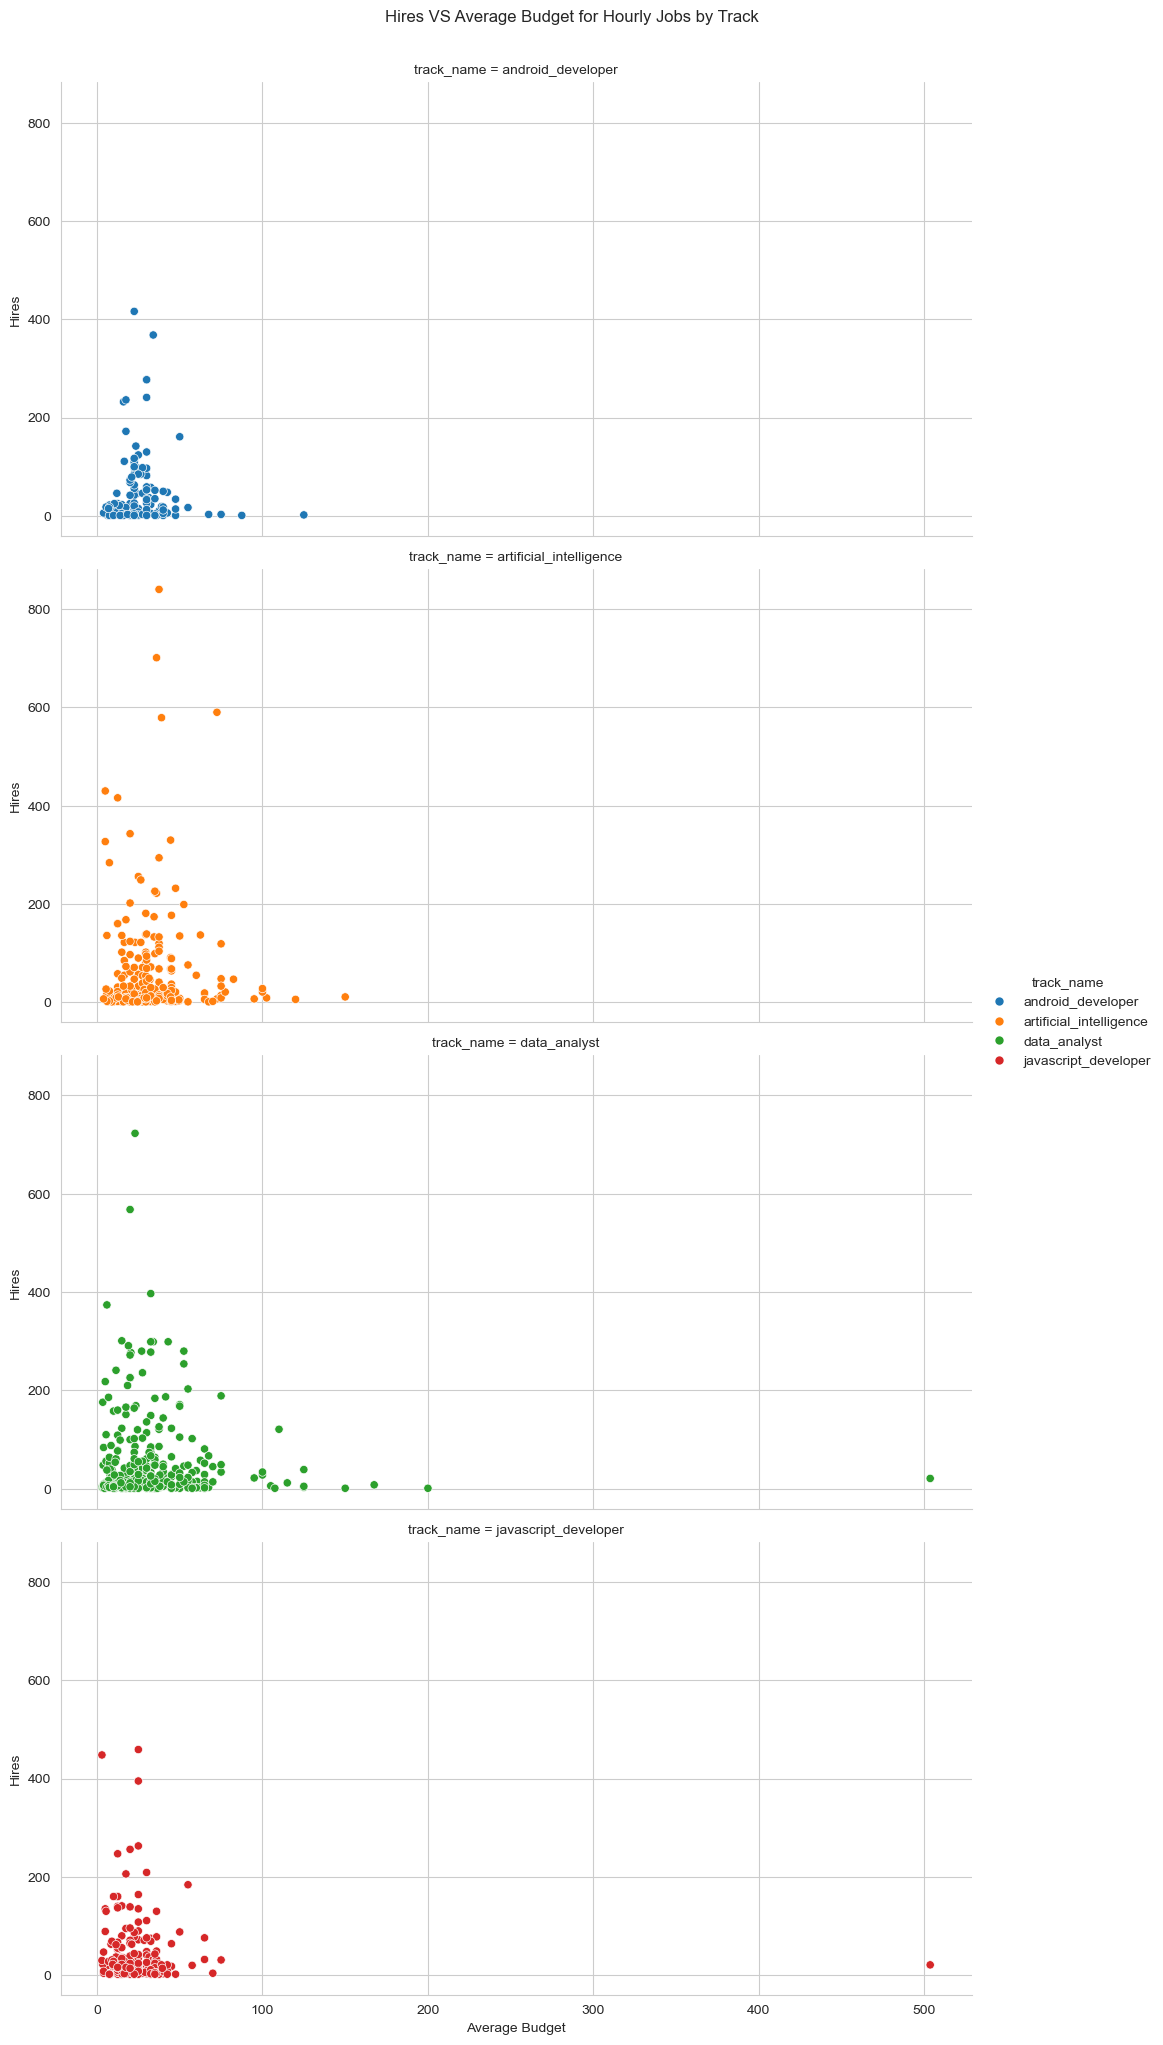

In [182]:
g = sns.relplot(
    data=hourly_average_budget,
    x="average_budget", 
    y="hires", 
    hue="track_name", 
    kind="scatter", 
    row="track_name", 
    height=5,
    aspect=2
    )

g.figure.suptitle("Hires VS Average Budget for Hourly Jobs by Track", y=1.02)
g.set_axis_labels("Average Budget", "Hires")
plt.show()

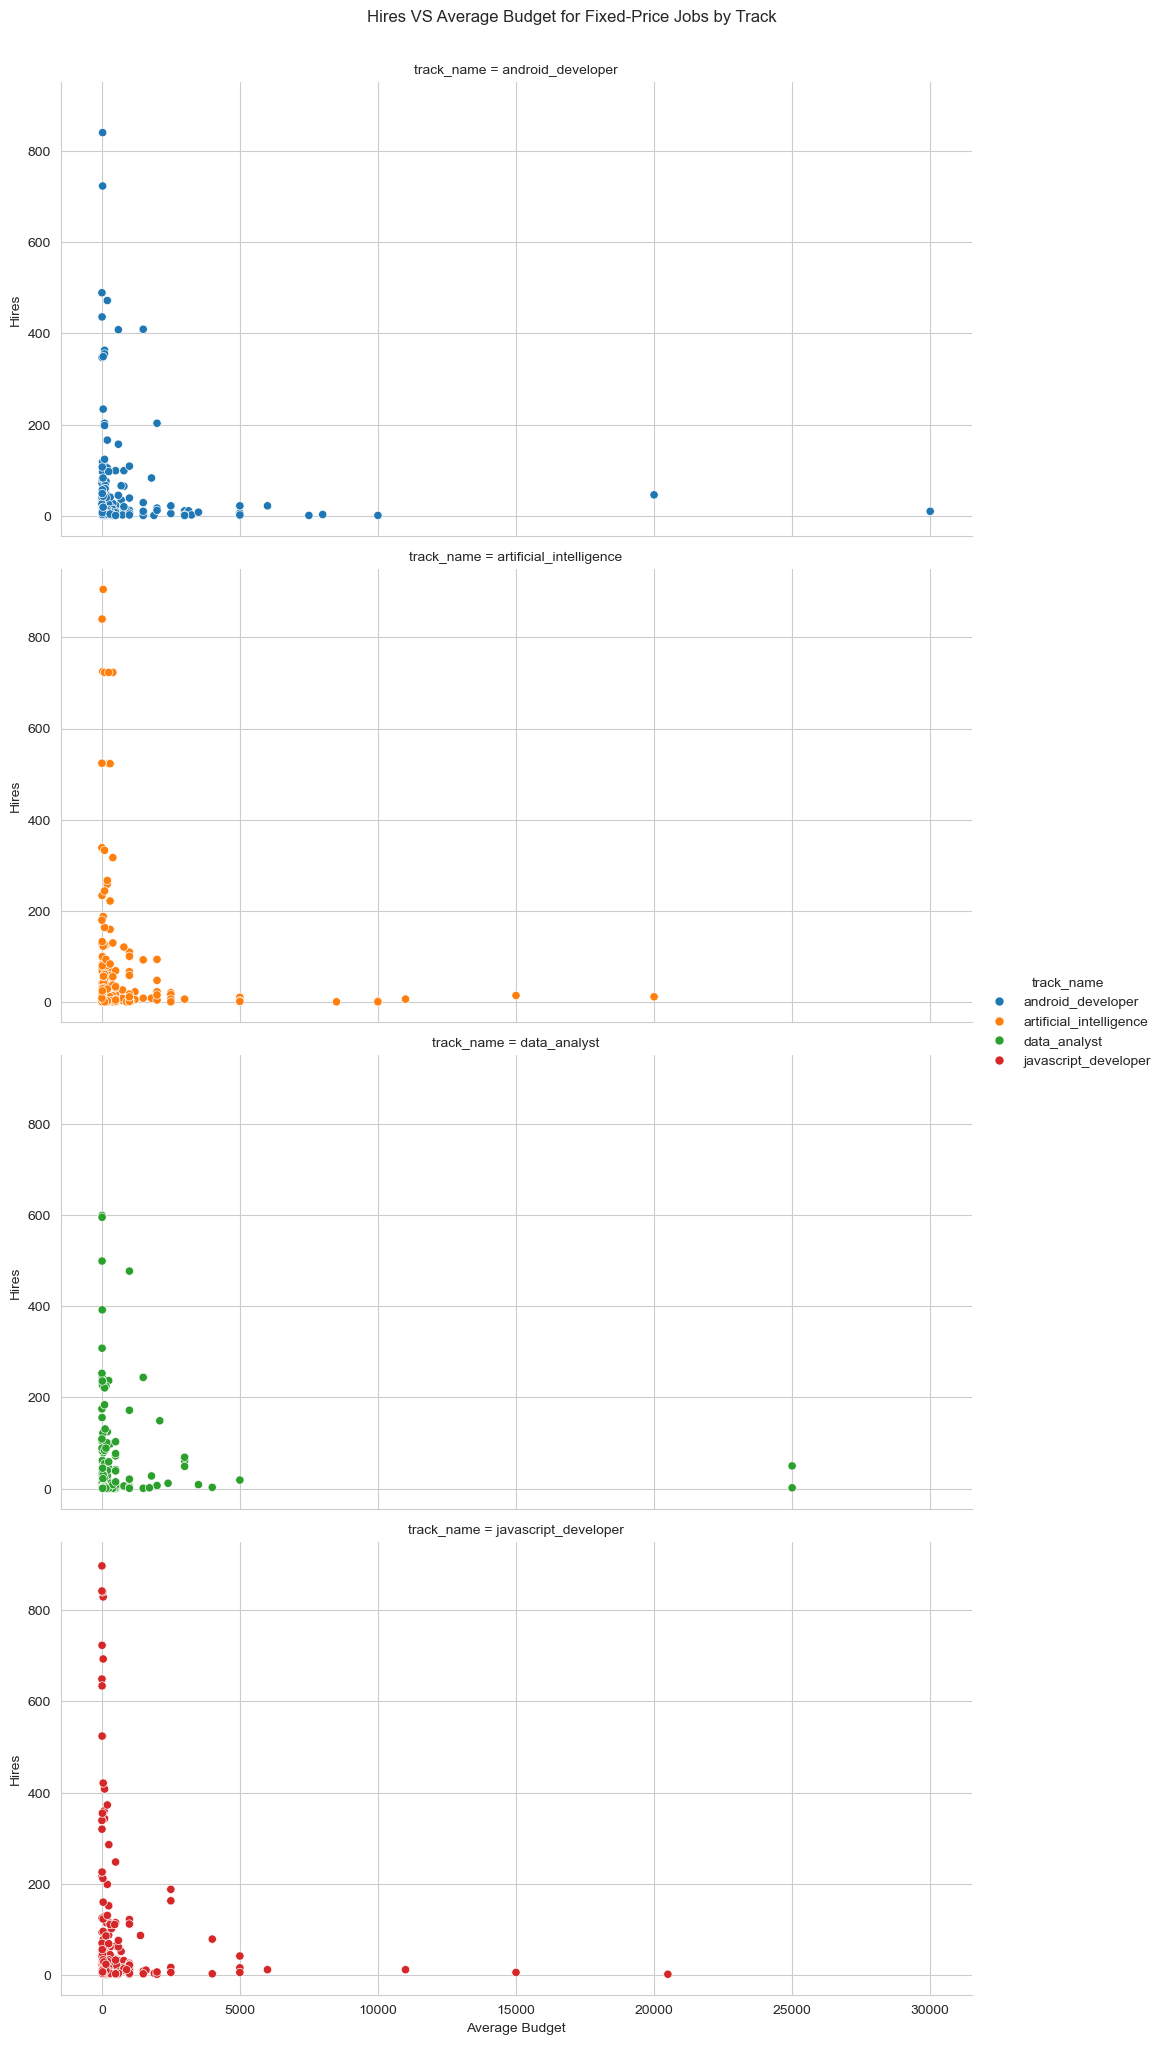

In [183]:
g = sns.relplot(
    data=fixed_price_average_budget,
    x="average_budget", 
    y="hires", 
    hue="track_name", 
    kind="scatter", 
    row="track_name", 
    height=5,
    aspect=2
    )

g.figure.suptitle("Hires VS Average Budget for Fixed-Price Jobs by Track", y=1.02)
g.set_axis_labels("Average Budget", "Hires")
plt.show()